<a href="https://colab.research.google.com/github/Zen204/-My-eCornell-Portfolio/blob/main/Copy_of_GraphDB_GettingStarted.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Started Notes

Project FAQs can be found (or added to) [here](https://docs.google.com/spreadsheets/d/1Av01IrDMITM5haDGDFq1DemD4W28fDLjJD9S9ewUQig/edit?usp=sharing)

1) you'll want to accept the invitation to the Neo4j Aura Tenant, which may require you to create an account (free)

2) go to [the Neo4j Aura console](console.neo4j.io) to log in

3) once logged in, find the "BTT AI ACN" Organization/Tenant

4) there are 2 'instances' in the project, you are interested in "TechNewsGraph_BTT"
- Note: data is still being loaded to this graph

5) if you "open" this instance, you're taken to a Neo4j Workspace where you can

- query the graph (Neo4j's query language is called "Cypher", and AI assistants know a bit about how to write Cypher)
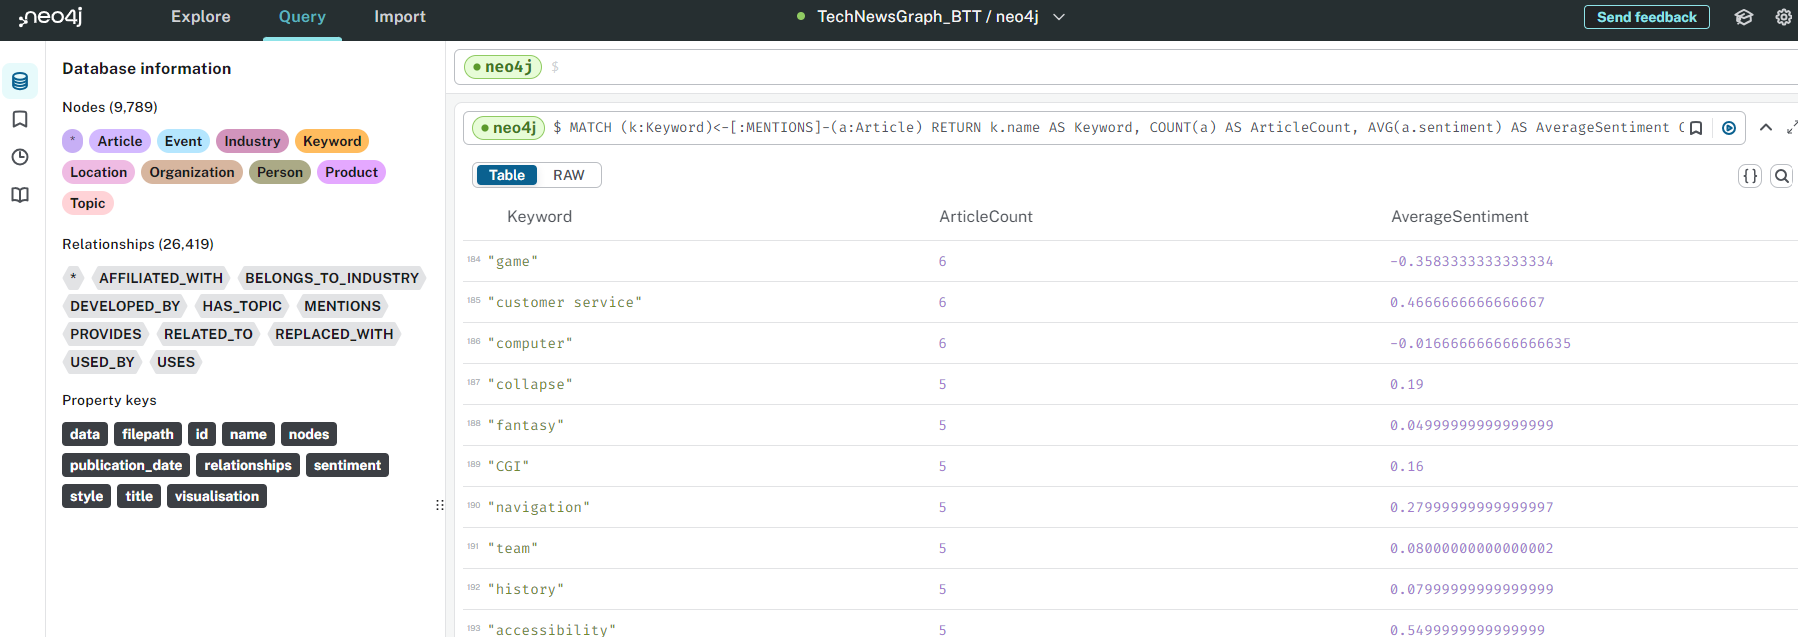

- visualize/explore the graph
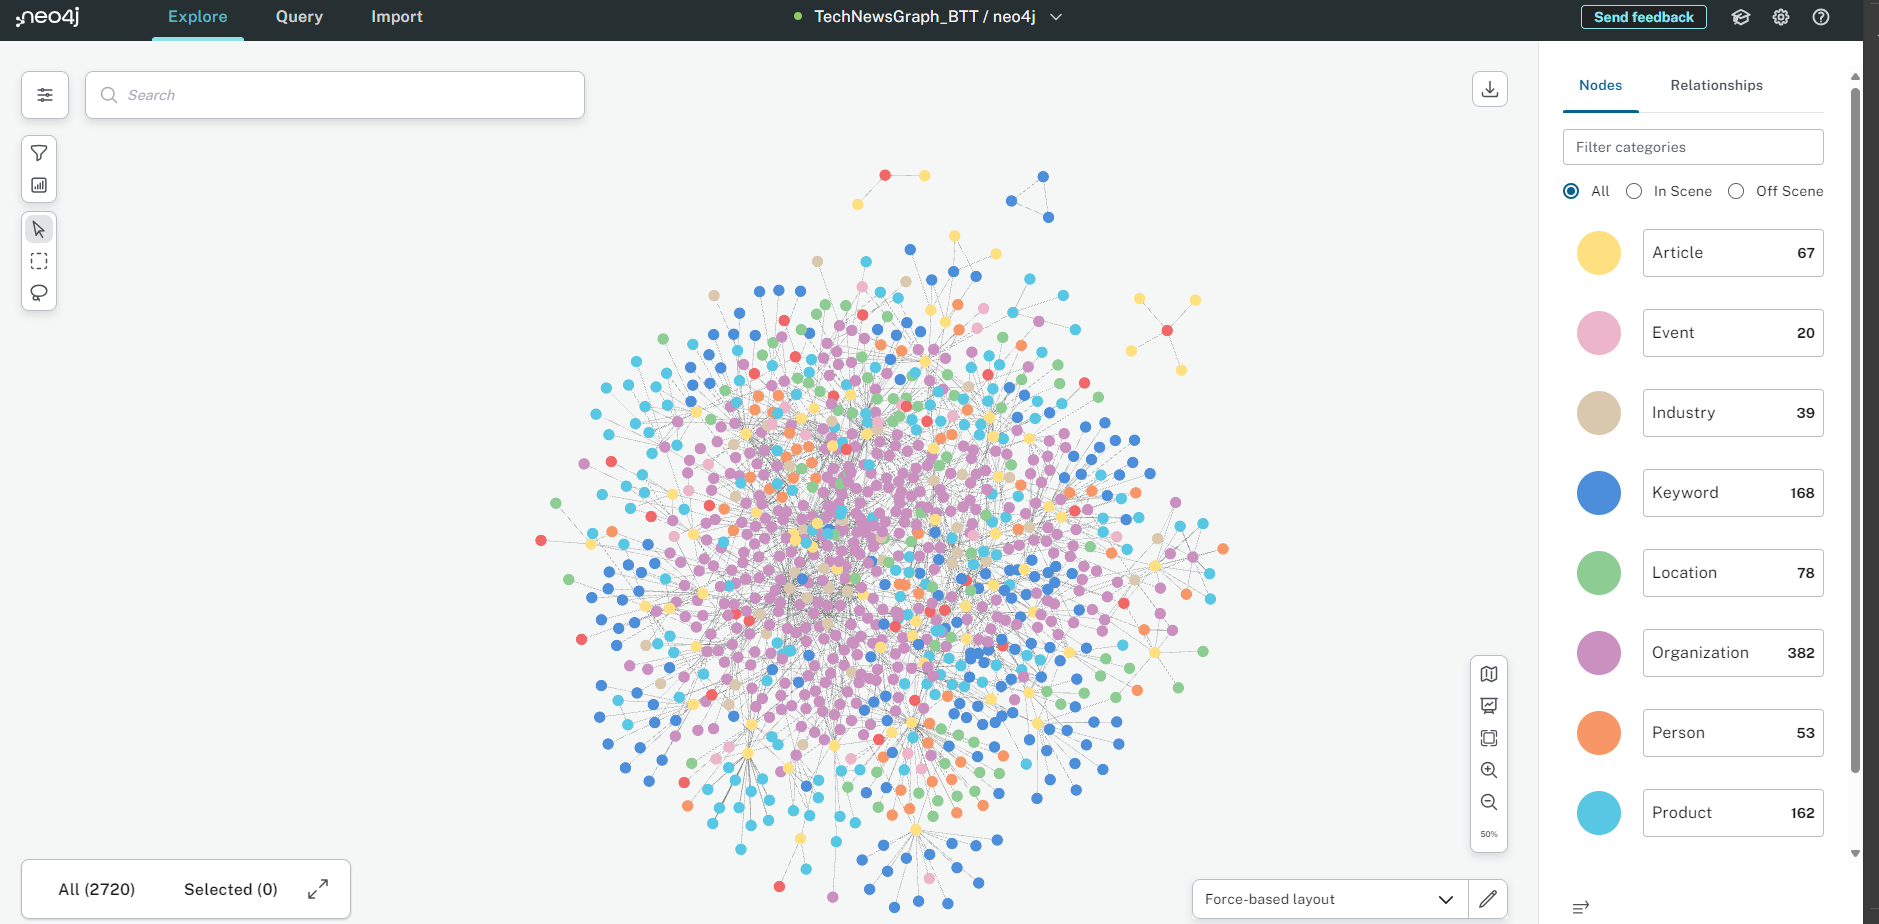


# Setup

In [ ]:
!pip install neo4j

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.7/301.7 kB 11.6 MB/s eta 0:00:00


In [ ]:
# Import libraries
import pandas as pd
from neo4j import GraphDatabase

# Connect to the Database

Note: there are multiple instances of the graph, so it's not catastrophic if this happens, but do not use any DELETE commands, since it's possible to do so with this key

In [ ]:
# clone to new graph instance
neo4j_pass_prof = "Fpz12jA1x46VDU0j53kGGTspKb1nVgeqT5xb3mYeNI0"
driver = GraphDatabase.driver("neo4j+s://2003b312.databases.neo4j.io", auth=("neo4j", neo4j_pass_prof))

# View Database Schema

you might want to do this, so you can get a little help, like I did [here](https://chatgpt.com/share/66eb9dfd-4440-8001-8f6b-92ce6292ae6f)

In [ ]:
# view graph schema
def get_graph_schema():
    with driver.session() as session:
        # Run the APOC procedure to get the schema
        result = session.run(
            """
            CALL apoc.meta.schema()
            """
        )
        # Extract the schema information
        schema = result.single()
        return schema

# Usage
graph_schema = get_graph_schema()
display(graph_schema)

<Record value={'Keyword': {'count': 1877, 'labels': [], 'properties': {'name': {'unique': False, 'indexed': False, 'type': 'STRING', 'existence': False}}, 'type': 'node', 'relationships': {'HAS_TOPIC': {'count': 0, 'direction': 'out', 'labels': ['Topic', 'Article', 'Product', 'Event'], 'properties': {}}, 'MENTIONS': {'count': 20965, 'direction': 'in', 'labels': ['Article', 'Organization', 'Person', 'Product'], 'properties': {}}, 'AFFILIATED_WITH': {'count': 1077, 'direction': 'in', 'labels': ['Person'], 'properties': {}}, 'USES': {'count': 84, 'direction': 'in', 'labels': ['Product'], 'properties': {}}, 'RELATED_TO': {'count': 20, 'direction': 'out', 'labels': ['Keyword', 'Product', 'Organization', 'Person', 'Product', 'Location', 'Event', 'Keyword'], 'properties': {}}, 'BELONGS_TO_INDUSTRY': {'count': 0, 'direction': 'out', 'labels': ['Industry', 'Organization'], 'properties': {}}, 'USED_BY': {'count': 21, 'direction': 'in', 'labels': ['Organization', 'Product', 'Event'], 'properties'

# Node Summaries

In [ ]:
def get_node_type_counts():
    with driver.session() as session:
        # Run the Cypher query
        result = session.run(
            """
            MATCH (n)
            RETURN labels(n) AS NodeType, COUNT(n) AS Count
            ORDER BY Count DESC
            """
        )

        # Extract results and convert to a pandas DataFrame
        data = [{"NodeType": record["NodeType"], "Count": record["Count"]} for record in result]
        df = pd.DataFrame(data)

        return df

# Retrieve the node type counts and display as a DataFrame
node_type_counts_df = get_node_type_counts()
display(node_type_counts_df)

,NodeType,Count
0,[Organization],11155
1,[Entity],4160
2,[Product],4143
3,[Article],3684
4,[Keyword],1877
5,[Person],1651
6,[Location],762
7,[Event],625
8,[Industry],249
9,[Topic],89


# Sentiment by Keyword

In [ ]:
def get_average_sentiment_for_keywords():
    with driver.session() as session:
        result = session.run(
            """
            MATCH (k:Keyword)<-[:MENTIONS]-(a:Article)
            RETURN k.name AS Keyword, AVG(a.sentiment) AS average_sentiment
            ORDER BY average_sentiment DESC
            LIMIT 10
            """
        )

        # Convert results to DataFrame
        data = [{"Keyword": record["Keyword"], "average_sentiment": record["average_sentiment"]} for record in result]
        df = pd.DataFrame(data)

        return df

# Usage
average_sentiment_df = get_average_sentiment_for_keywords()
print(average_sentiment_df)


          Keyword  average_sentiment
0            give                NaN
1    Saudi Arabia                NaN
2             GPS               0.90
3      commitment               0.90
4  cinematography               0.85
5     perspective               0.85
6    customisable               0.85
7       prismatic               0.85
8      excellence               0.85
9     carbonfibre               0.85


# Article Count by Topic/Date

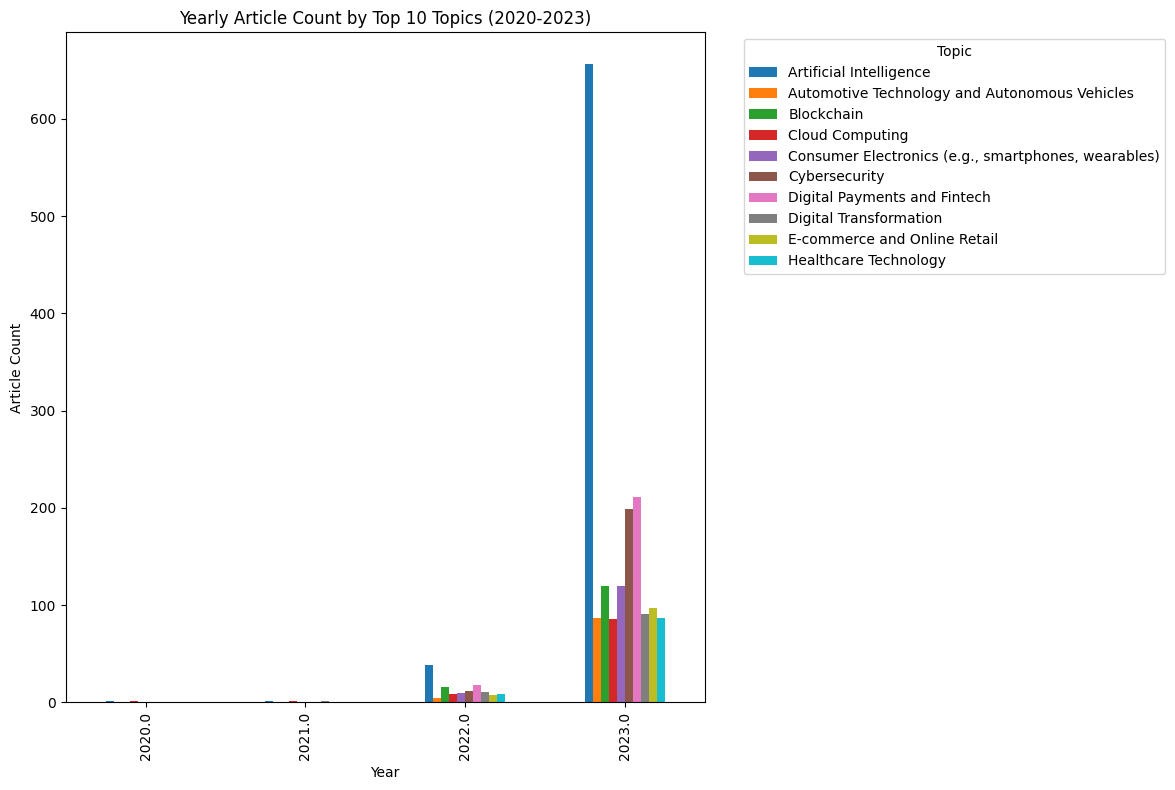

,topic_name,year,month,article_count
0,5G Technology,2022.0,11.0,1
1,5G Technology,2022.0,12.0,5
2,5G Technology,2023.0,1.0,8
3,5G Technology,2023.0,2.0,5
4,5G Technology,2023.0,3.0,8
...,...,...,...,...
562,Web Development,2023.0,1.0,1
563,Web Development,2023.0,4.0,2
564,Web Development,2023.0,7.0,1
565,Web Development,2023.0,9.0,2


In [ ]:
import matplotlib.pyplot as plt
def get_article_count_by_topic_and_date():
    with driver.session() as session:
        result = session.run(
            """
            MATCH (a:Article)-[:HAS_TOPIC]->(t:Topic)
            WITH t.name AS topic_name, date(a.publication_date) AS pub_date, a
            RETURN topic_name, pub_date.year AS year, pub_date.month AS month, COUNT(a) AS article_count
            ORDER BY topic_name, year, month
            """
        )

        # Convert results to DataFrame
        data = [{"topic_name": record["topic_name"], "year": record["year"], "month": record["month"], "article_count": record["article_count"]} for record in result]
        df = pd.DataFrame(data)

        # Filter for specific years
        df_filtered = df[df['year'].isin([2019, 2020, 2021, 2022, 2023, 2024])]

        # Step 2: Aggregate data by year and topic
        yearly_data = df_filtered.groupby(['topic_name', 'year'])['article_count'].sum().reset_index()

        # Step 3: Get total counts per topic and filter top 10 topics
        top_topics = yearly_data.groupby('topic_name')['article_count'].sum().nlargest(10).index
        yearly_data_top = yearly_data[yearly_data['topic_name'].isin(top_topics)]

        # Step 4: Pivot the data for easier plotting
        pivot_data = yearly_data_top.pivot(index='year', columns='topic_name', values='article_count')

        # Step 5: Plotting
        pivot_data.plot(kind='bar', figsize=(12, 8))
        plt.title("Yearly Article Count by Top 10 Topics (2020-2023)")
        plt.xlabel("Year")
        plt.ylabel("Article Count")
        plt.legend(title="Topic", bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()


        return df

# Usage
article_count_by_topic_and_date_df = get_article_count_by_topic_and_date()
display(article_count_by_topic_and_date_df)


In [ ]:
!pip install prophet

,topic_name,year,month,article_count,avg_sentiment
0,5G Technology,2022.0,11.0,1,0.8500
1,5G Technology,2022.0,12.0,5,0.1800
2,5G Technology,2023.0,1.0,8,0.3625
3,5G Technology,2023.0,2.0,5,0.2400
4,5G Technology,2023.0,3.0,8,0.3875
...,...,...,...,...,...
536,Web Development,2023.0,1.0,1,0.8500
537,Web Development,2023.0,4.0,2,0.2750
538,Web Development,2023.0,7.0,1,0.3000
539,Web Development,2023.0,9.0,2,0.7500


<ipython-input-50-9c249f41f56c>:42: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

INFO:prophet:n_changepoints greater than number of observations. Using 9.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpchkojv29/2n59fmw0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpchkojv29/76liolr4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35837', 'data', 'file=/tmp/tmpchkojv29/2n59fmw0.json', 'init=/tmp/tmpchkojv29/76liolr4.json', 'output', 'file=/tmp/tmpchkojv29/prophet_modelxyxmwher/prophet_model-20241130030315.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:03:15 - cmdstanpy - INFO - Chain [

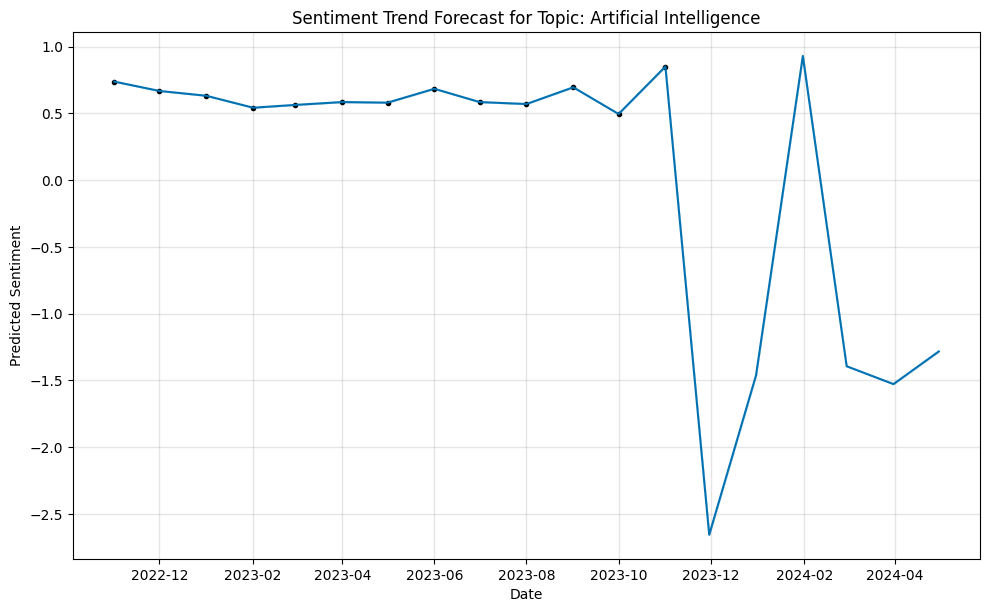

<ipython-input-50-9c249f41f56c>:42: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

INFO:prophet:n_changepoints greater than number of observations. Using 8.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpchkojv29/fhkqr1lb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpchkojv29/kcy8jo1h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79635', 'data', 'file=/tmp/tmpchkojv29/fhkqr1lb.json', 'init=/tmp/tmpchkojv29/kcy8jo1h.json', 'output', 'file=/tmp/tmpchkojv29/prophet_model1ay71q9v/prophet_model-20241130030325.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:03:25 - cmdstanpy - INFO - Chain [

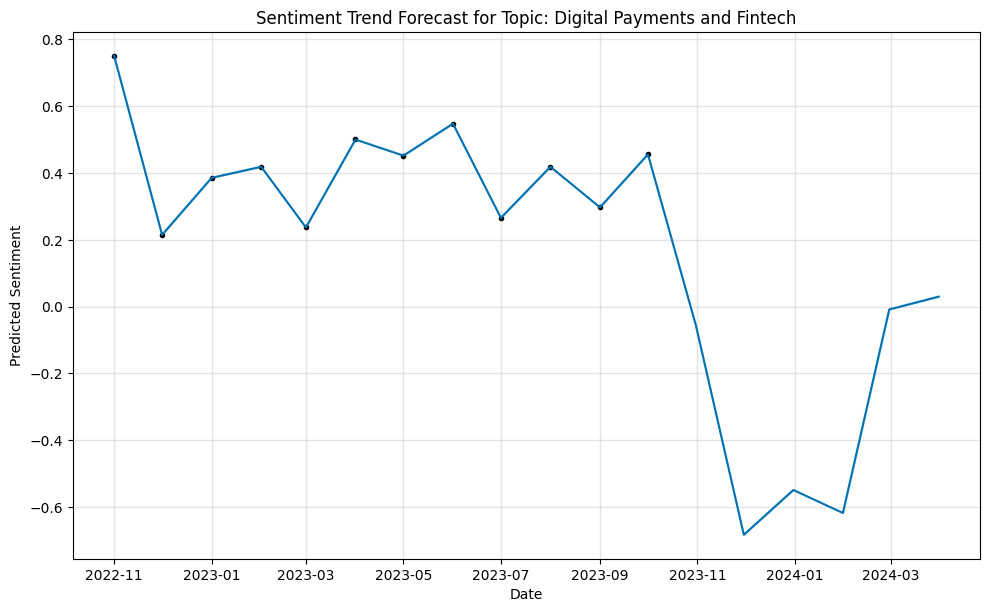

<ipython-input-50-9c249f41f56c>:42: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

INFO:prophet:n_changepoints greater than number of observations. Using 8.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpchkojv29/q90lx60s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpchkojv29/z1_mdi8p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91937', 'data', 'file=/tmp/tmpchkojv29/q90lx60s.json', 'init=/tmp/tmpchkojv29/z1_mdi8p.json', 'output', 'file=/tmp/tmpchkojv29/prophet_modelw32q50vy/prophet_model-20241130030400.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:04:00 - cmdstanpy - INFO - Chain [

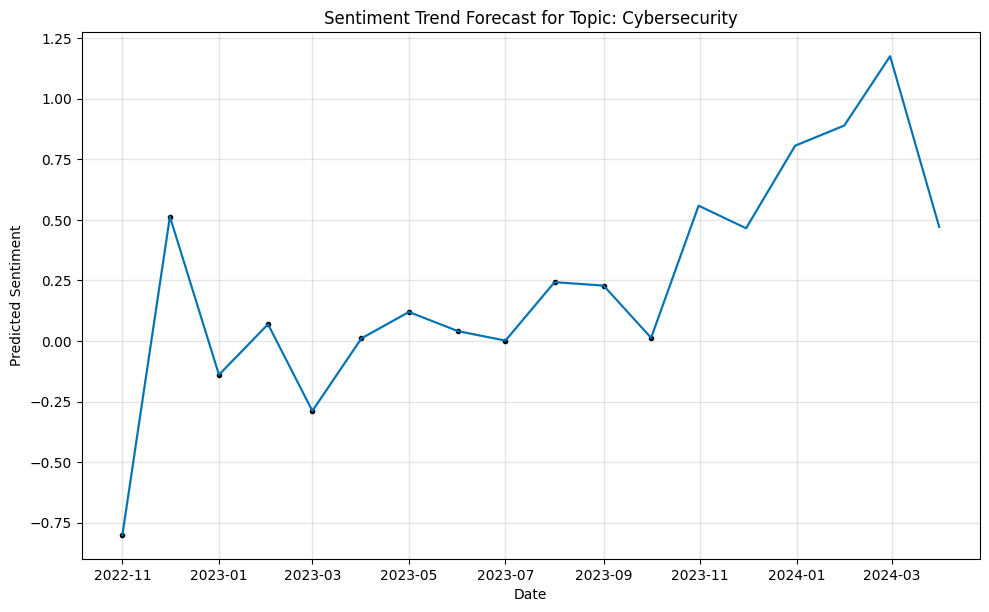

<ipython-input-50-9c249f41f56c>:42: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

INFO:prophet:n_changepoints greater than number of observations. Using 8.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpchkojv29/a_jg7dsv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpchkojv29/1tptspm3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86026', 'data', 'file=/tmp/tmpchkojv29/a_jg7dsv.json', 'init=/tmp/tmpchkojv29/1tptspm3.json', 'output', 'file=/tmp/tmpchkojv29/prophet_modelb8c_4cn3/prophet_model-20241130030425.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:04:25 - cmdstanpy - INFO - Chain [

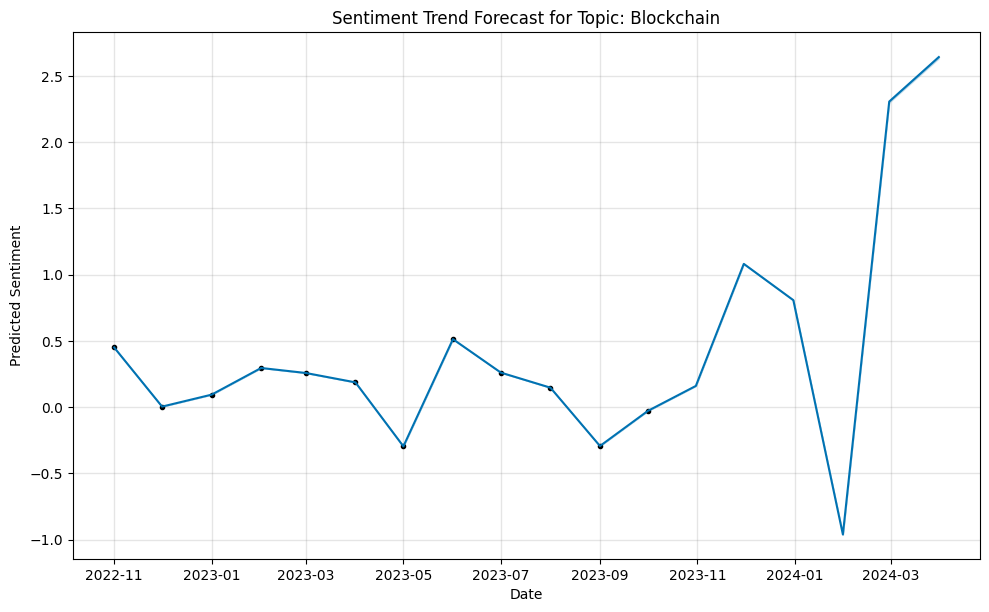

<ipython-input-50-9c249f41f56c>:42: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

INFO:prophet:n_changepoints greater than number of observations. Using 8.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpchkojv29/jswyrx13.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpchkojv29/ujbr6ikx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26395', 'data', 'file=/tmp/tmpchkojv29/jswyrx13.json', 'init=/tmp/tmpchkojv29/ujbr6ikx.json', 'output', 'file=/tmp/tmpchkojv29/prophet_modelx04__sp_/prophet_model-20241130030439.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:04:39 - cmdstanpy - INFO - Chain [

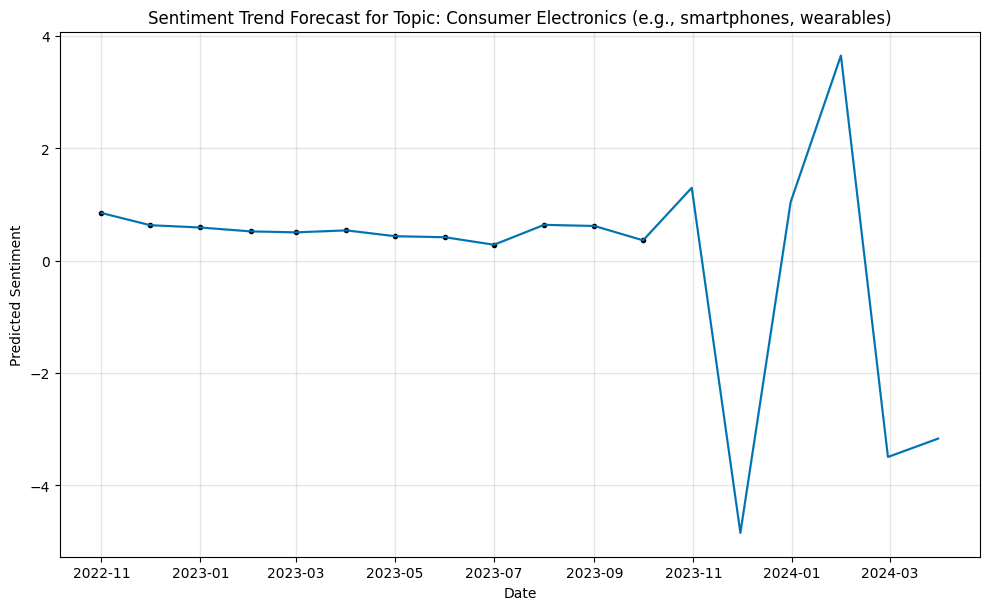

In [ ]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt

# Get article count and sentiment data
def get_article_count_and_sentiment_by_topic_and_date():
    with driver.session() as session:
        result = session.run(
            """
            MATCH (a:Article)-[:HAS_TOPIC]->(t:Topic)
            WITH t.name AS topic_name, date(a.publication_date) AS pub_date, a
            RETURN topic_name, pub_date.year AS year, pub_date.month AS month,
                   COUNT(a) AS article_count, AVG(a.sentiment) AS avg_sentiment
            ORDER BY topic_name, year, month
            """
        )

        data = [{"topic_name": record["topic_name"], "year": record["year"], "month": record["month"],
                 "article_count": record["article_count"], "avg_sentiment": record["avg_sentiment"]} for record in result]
        df = pd.DataFrame(data)

        # Filter for specific years
        df_filtered = df[df['year'].isin([2022, 2023])]

        # Aggregate data
        yearly_data = df_filtered.groupby(['topic_name', 'year', 'month']).agg(
            article_count=('article_count', 'sum'),
            avg_sentiment=('avg_sentiment', 'mean')
        ).reset_index()

        return yearly_data

# Step 3: Forecast Sentiment Trends Using Prophet
def forecast_sentiment_trends(df):
    # Determine top 5 topics based on article count
    top_topics = df.groupby('topic_name')['article_count'].sum().nlargest(5).index

    for topic in top_topics:
        topic_data = df[df['topic_name'] == topic]

        # Prepare data for Prophet: Date and sentiment score
        topic_data['date'] = pd.to_datetime(topic_data[['year', 'month']].assign(day=1))
        prophet_data = topic_data[['date', 'avg_sentiment']].rename(columns={'date': 'ds', 'avg_sentiment': 'y'})

        # Initialize and tune Prophet model
        model = Prophet(
            seasonality_mode='multiplicative',  # Change to multiplicative if seasonality impacts sentiment non-linearly
            yearly_seasonality=True,
            weekly_seasonality=False,
            daily_seasonality=False
        )
        model.add_seasonality(name='monthly', period=30.5, fourier_order=5)  # Add tuned monthly seasonality

        model.fit(prophet_data)

        # Make future predictions (next 6 months)
        future = model.make_future_dataframe(periods=6, freq='M')
        forecast = model.predict(future)

        # Plot forecasted sentiment trend
        fig = model.plot(forecast)
        plt.title(f"Sentiment Trend Forecast for Topic: {topic}")
        plt.xlabel("Date")
        plt.ylabel("Predicted Sentiment")
        plt.show()


# Usage
article_data_df = get_article_count_and_sentiment_by_topic_and_date()
display(article_data_df)

# Forecast and visualize trends for the top 5 topics
forecast_sentiment_trends(article_data_df)

,topic_name,year,month,article_count,avg_sentiment
0,5G Technology,2022.0,11.0,1,0.8500
1,5G Technology,2022.0,12.0,5,0.1800
2,5G Technology,2023.0,1.0,8,0.3625
3,5G Technology,2023.0,2.0,5,0.2400
4,5G Technology,2023.0,3.0,8,0.3875
...,...,...,...,...,...
551,Web Development,2023.0,1.0,1,0.8500
552,Web Development,2023.0,4.0,2,0.2750
553,Web Development,2023.0,7.0,1,0.3000
554,Web Development,2023.0,9.0,2,0.7500


INFO:prophet:n_changepoints greater than number of observations. Using 11.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpchkojv29/dq9b69uj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpchkojv29/qqy0gda2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9941', 'data', 'file=/tmp/tmpchkojv29/dq9b69uj.json', 'init=/tmp/tmpchkojv29/qqy0gda2.json', 'output', 'file=/tmp/tmpchkojv29/prophet_model15imr4bq/prophet_model-20241130030446.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:04:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:04:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.10/dist-packages/prophet/forecaster.py:1854: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

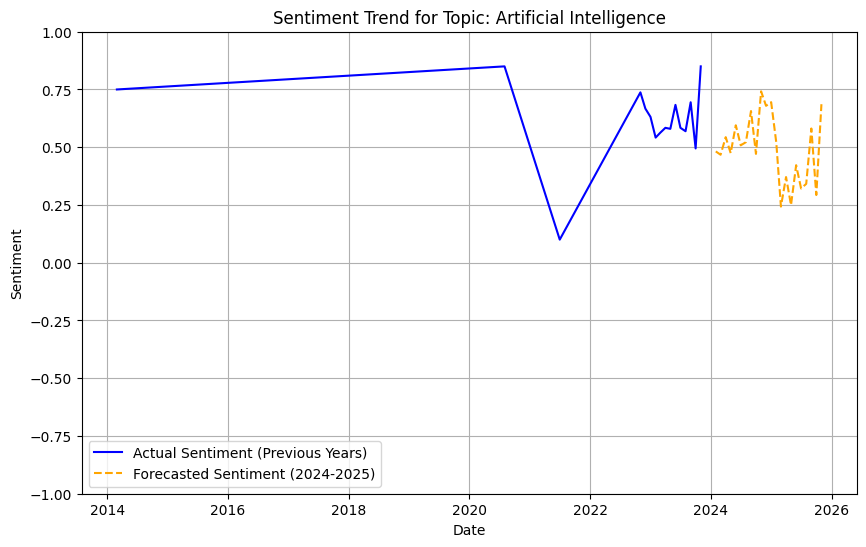

INFO:prophet:n_changepoints greater than number of observations. Using 8.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpchkojv29/54gsk2x4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpchkojv29/_05vkbay.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62389', 'data', 'file=/tmp/tmpchkojv29/54gsk2x4.json', 'init=/tmp/tmpchkojv29/_05vkbay.json', 'output', 'file=/tmp/tmpchkojv29/prophet_modelny1qbka5/prophet_model-20241130030456.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:04:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:05:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.10/dist-packages/prophet/forecaster.py:1854: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

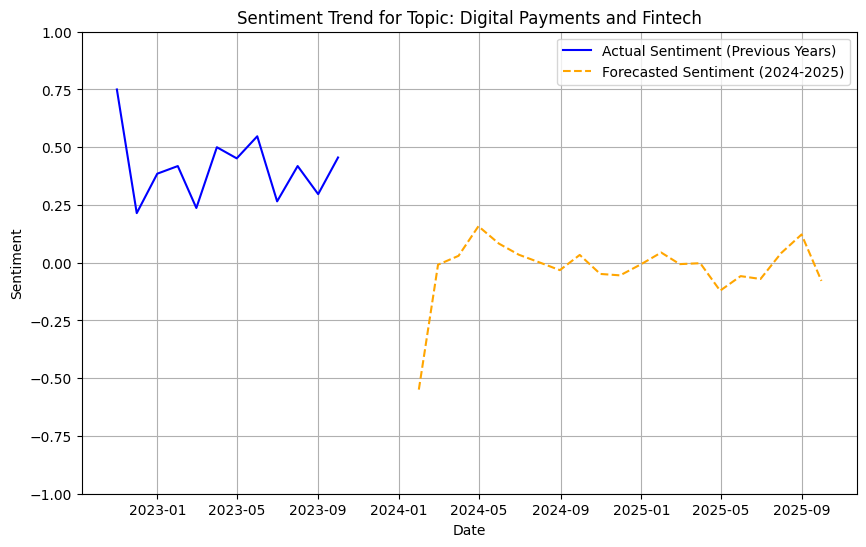

INFO:prophet:n_changepoints greater than number of observations. Using 8.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpchkojv29/e0c9awim.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpchkojv29/0lp_s7o2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2909', 'data', 'file=/tmp/tmpchkojv29/e0c9awim.json', 'init=/tmp/tmpchkojv29/0lp_s7o2.json', 'output', 'file=/tmp/tmpchkojv29/prophet_modelrr6ybb_e/prophet_model-20241130030531.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:05:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:05:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.10/dist-packages/prophet/forecaster.py:1854: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.


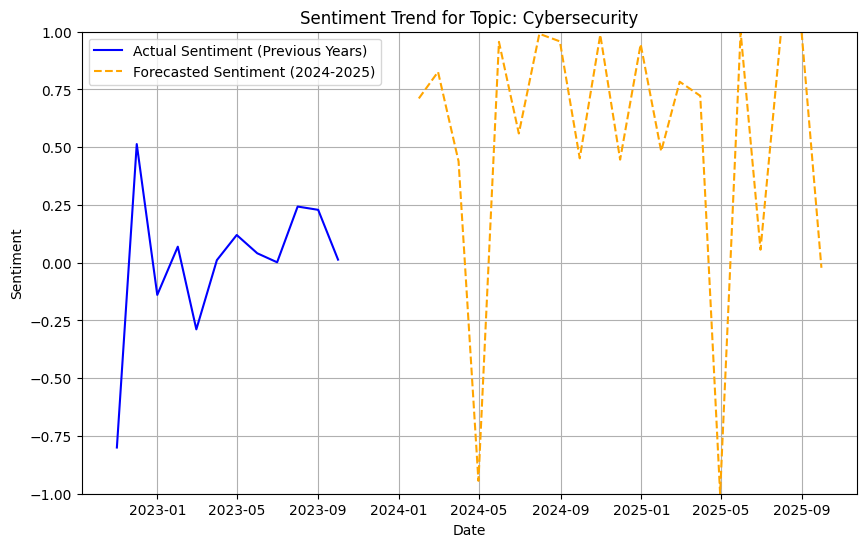

INFO:prophet:n_changepoints greater than number of observations. Using 8.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpchkojv29/jw9dmsve.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpchkojv29/t7zcezm5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=930', 'data', 'file=/tmp/tmpchkojv29/jw9dmsve.json', 'init=/tmp/tmpchkojv29/t7zcezm5.json', 'output', 'file=/tmp/tmpchkojv29/prophet_model4y65qxyr/prophet_model-20241130030559.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:05:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:06:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.10/dist-packages/prophet/forecaster.py:1854: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



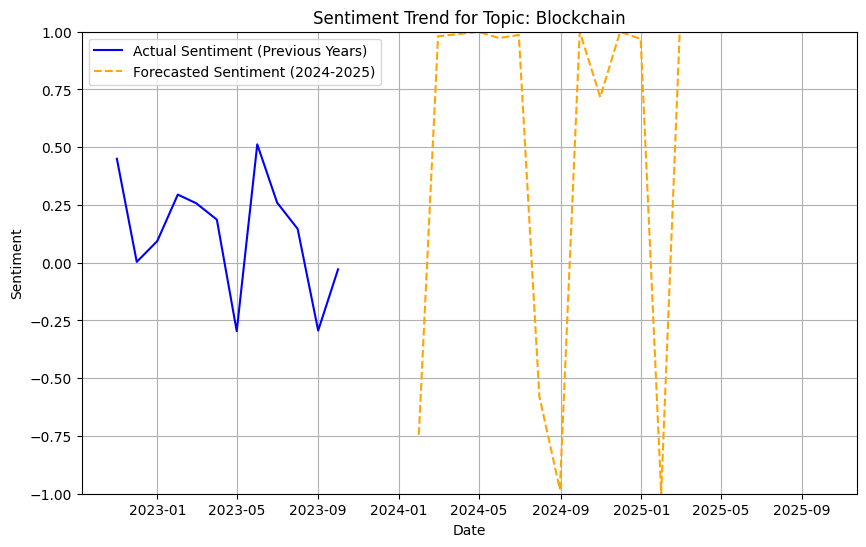

INFO:prophet:n_changepoints greater than number of observations. Using 8.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpchkojv29/z2izktit.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpchkojv29/l6pjjf1r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36724', 'data', 'file=/tmp/tmpchkojv29/z2izktit.json', 'init=/tmp/tmpchkojv29/l6pjjf1r.json', 'output', 'file=/tmp/tmpchkojv29/prophet_model3dpdcw78/prophet_model-20241130030614.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:06:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:06:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.10/dist-packages/prophet/forecaster.py:1854: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

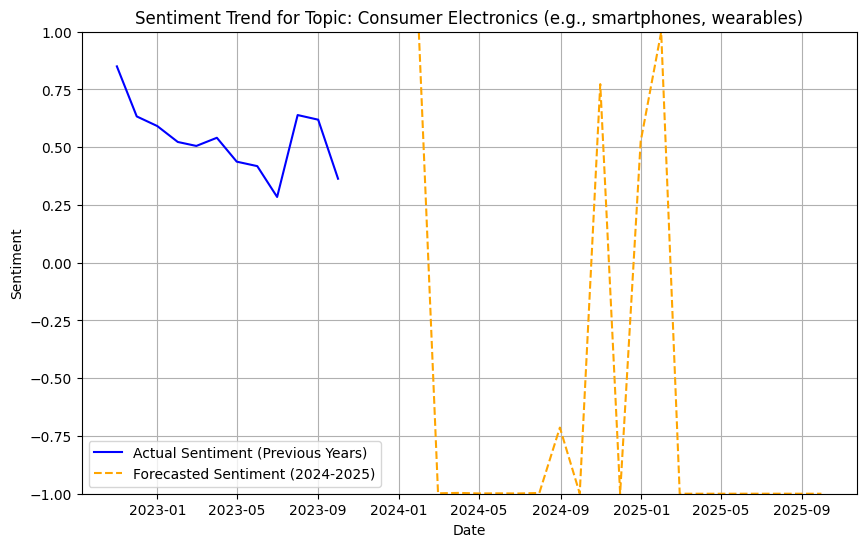

In [ ]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Get article count and sentiment data
def get_article_count_and_sentiment_by_topic_and_date():
    with driver.session() as session:
        result = session.run(
            """
            MATCH (a:Article)-[:HAS_TOPIC]->(t:Topic)
            WITH t.name AS topic_name, date(a.publication_date) AS pub_date, a
            RETURN topic_name, pub_date.year AS year, pub_date.month AS month,
                   COUNT(a) AS article_count, AVG(a.sentiment) AS avg_sentiment
            ORDER BY topic_name, year, month
            """
        )

        data = [{"topic_name": record["topic_name"], "year": record["year"], "month": record["month"],
                 "article_count": record["article_count"], "avg_sentiment": record["avg_sentiment"]} for record in result]
        df = pd.DataFrame(data)

        # Filter for the past 10 years
        current_year = pd.Timestamp.now().year
        df_filtered = df[df['year'].between(current_year - 10, current_year)]

        # Aggregate data
        yearly_data = df_filtered.groupby(['topic_name', 'year', 'month']).agg(
            article_count=('article_count', 'sum'),
            avg_sentiment=('avg_sentiment', 'mean')
        ).reset_index()

        return yearly_data

# Forecast Sentiment Trends Using Prophet
def forecast_sentiment_trends(df):
    # Determine top 5 topics based on article count
    top_topics = df.groupby('topic_name')['article_count'].sum().nlargest(5).index

    for topic in top_topics:
        topic_data = df[df['topic_name'] == topic].copy()  # Use .copy() to avoid SettingWithCopyWarning

        # Prepare data for Prophet: Date and sentiment score
        topic_data.loc[:, 'date'] = pd.to_datetime(topic_data[['year', 'month']].assign(day=1))
        prophet_data = topic_data[['date', 'avg_sentiment']].rename(columns={'date': 'ds', 'avg_sentiment': 'y'})

        # Initialize and tune Prophet model
        model = Prophet(
            seasonality_mode='multiplicative',
            yearly_seasonality=True,
            weekly_seasonality=False,
            daily_seasonality=False
        )
        model.add_seasonality(name='monthly', period=30.5, fourier_order=5)

        try:
            model.fit(prophet_data)
        except ValueError as e:
            print(f"Insufficient data for topic '{topic}'. Skipping...")
            continue

        # Make future predictions for 2024 through 2025
        future = model.make_future_dataframe(periods=24, freq='M')  # 24 months of future data
        forecast = model.predict(future)

        # Apply logistic function to bound sentiment scores between -1 and 1
        forecast['yhat'] = np.tanh(forecast['yhat'])

        # Filter forecast for 2024 and 2025
        forecast_2024_2025 = forecast[forecast['ds'].dt.year.isin([2024, 2025])]

        if forecast_2024_2025.empty:
            print(f"No future dates for topic '{topic}' in 2024-2025. Skipping...")
            continue

        # Plot actual and forecasted sentiment
        plt.figure(figsize=(10, 6))

        # Plot actual sentiment from previous years
        plt.plot(
            topic_data['date'],
            topic_data['avg_sentiment'],
            label='Actual Sentiment (Previous Years)',
            color='blue'
        )

        # Plot forecasted sentiment for 2024-2025
        plt.plot(
            forecast_2024_2025['ds'],
            forecast_2024_2025['yhat'],
            label='Forecasted Sentiment (2024-2025)',
            color='orange',
            linestyle='--'
        )

        # Graph customization
        plt.title(f"Sentiment Trend for Topic: {topic}")
        plt.xlabel("Date")
        plt.ylabel("Sentiment")
        plt.ylim(-1, 1)
        plt.legend()
        plt.grid()

        # Show the plot
        plt.show()

# Usage
article_data_df = get_article_count_and_sentiment_by_topic_and_date()
display(article_data_df)

# Forecast and visualize trends for the top 5 topics
forecast_sentiment_trends(article_data_df)

# Keyword Co-Occurrence

In [ ]:
def get_keyword_co_occurrence():
    with driver.session() as session:
        result = session.run(
            """
            MATCH (a:Article)-[:MENTIONS]->(k1:Keyword), (a)-[:MENTIONS]->(k2:Keyword)
            WHERE k1 <> k2
            RETURN k1.name AS Keyword1, k2.name AS Keyword2, COUNT(a) AS co_occurrence_count
            ORDER BY co_occurrence_count DESC
            LIMIT 1000
            """
        )

        # Convert results to DataFrame
        data = [{"Keyword1": record["Keyword1"], "Keyword2": record["Keyword2"], "co_occurrence_count": record["co_occurrence_count"]} for record in result]
        df = pd.DataFrame(data)

        return df

# Usage
keyword_co_occurrence_df = get_keyword_co_occurrence()
display(keyword_co_occurrence_df.sample(10))



,Keyword1,Keyword2,co_occurrence_count
698,network,message,20
524,updates,facets,24
941,status,article,14
490,updates,economy,25
905,network,content,15
643,report,growth,23
979,communication,management,14
807,security,threats,17
209,response,security,28
62,technology,business,49


# Article Count by Topic

In [ ]:
def get_article_count_by_topic():
    with driver.session() as session:
        result = session.run(
            """
            MATCH (a:Article)-[:HAS_TOPIC]->(t:Topic)
            RETURN t.name AS topic_name, COUNT(a) AS article_count
            ORDER BY article_count DESC
            LIMIT 10
            """
        )

        # Convert results to DataFrame
        data = [{"topic_name": record["topic_name"], "article_count": record["article_count"]} for record in result]
        df = pd.DataFrame(data)

        return df

# Usage
article_count_by_topic_df = get_article_count_by_topic()
display(article_count_by_topic_df)


,topic_name,article_count
0,Artificial Intelligence,699
1,Digital Payments and Fintech,229
2,Cybersecurity,212
3,Blockchain,137
4,"Consumer Electronics (e.g., smartphones, weara...",130
5,E-commerce and Online Retail,105
6,Digital Transformation,104
7,Healthcare Technology,99
8,Cloud Computing,97
9,Automotive Technology and Autonomous Vehicles,93


# Top Keywords by Topic

In [ ]:
def get_mentions_of_keywords_by_topic():
    with driver.session() as session:
        result = session.run(
            """
            MATCH (a:Article)-[:HAS_TOPIC]->(t:Topic), (a)-[:MENTIONS]->(k:Keyword)
            RETURN t.name AS topic_name, k.name AS keyword, COUNT(a) AS mention_count
            ORDER BY topic_name, mention_count DESC
            """
        )

        # Convert results to DataFrame
        data = [{"topic_name": record["topic_name"], "keyword": record["keyword"], "mention_count": record["mention_count"]} for record in result]
        df = pd.DataFrame(data)

        return df

# Usage
mentions_of_keywords_by_topic_df = get_mentions_of_keywords_by_topic()
display(mentions_of_keywords_by_topic_df)


,topic_name,keyword,mention_count
0,5G Technology,trends,11
1,5G Technology,challenges,10
2,5G Technology,Telecom,10
3,5G Technology,insights,8
4,5G Technology,access,8
...,...,...,...
5804,Web Development,tutorials,1
5805,Web Development,skills,1
5806,Web Development,opportunities,1
5807,Web Development,metrics,1


In [ ]:
def analyze_keyword_influence_by_topic(df):
    """
    Analyzes the correlation and influence of keywords within topics using the provided data.

    Parameters:
        df (DataFrame): DataFrame containing 'topic_name', 'keyword', and 'mention_count'.

    Returns:
        corr_df (DataFrame): DataFrame containing correlation matrix for mention counts.
        influence_df (DataFrame): DataFrame containing keyword influence per topic.
    """
    # Pivot the data for correlation analysis
    pivot_df = df.pivot_table(
        index="keyword",
        columns="topic_name",
        values="mention_count",
        fill_value=0
    )

    # Compute the correlation matrix
    correlation_matrix = pivot_df.corr()

    # Calculate keyword influence (normalized mention count per topic)
    df["mention_normalized"] = (
        df.groupby("topic_name")["mention_count"]
        .transform(lambda x: (x - x.mean()) / x.std())
    )

    # Influence: Aggregate normalized scores by topic and keyword
    influence_df = df.groupby(["topic_name", "keyword"]).agg(
        influence_score=("mention_normalized", "sum")
    ).reset_index().sort_values(by=["topic_name", "influence_score"], ascending=[True, False])

    return correlation_matrix, influence_df

# Usage Example
mentions_of_keywords_by_topic_df = get_mentions_of_keywords_by_topic()

# Analyze correlations and influence
correlation_matrix, influence_df = analyze_keyword_influence_by_topic(mentions_of_keywords_by_topic_df)

# Display results
print("Correlation Matrix:")
print(correlation_matrix)

print("\nTop Keyword Influences by Topic:")
display(influence_df)


Correlation Matrix:
topic_name                                 5G Technology  \
topic_name                                                 
5G Technology                                   1.000000   
APIs and Integration                            0.064117   
Agriculture Technology (AgriTech)               0.167881   
Artificial Intelligence                         0.099273   
Augmented Reality (AR)                         -0.004164   
...                                                  ...   
Technology Conferences and Events               0.220262   
Technology Investment and Venture Capital       0.185070   
Unified Communications and Collaboration        0.094431   
Virtual Reality (VR)                            0.170523   
Web Development                                -0.009999   

topic_name                                 APIs and Integration  \
topic_name                                                        
5G Technology                                          0.064117  

,topic_name,keyword,influence_score
135,5G Technology,trends,3.774324
7,5G Technology,Telecom,3.337202
29,5G Technology,challenges,3.337202
8,5G Technology,access,2.462957
22,5G Technology,awards,2.462957
...,...,...,...
5804,Web Development,versions,-0.169031
5805,Web Development,vulnerability testing,-0.169031
5806,Web Development,web,-0.169031
5807,Web Development,web server,-0.169031


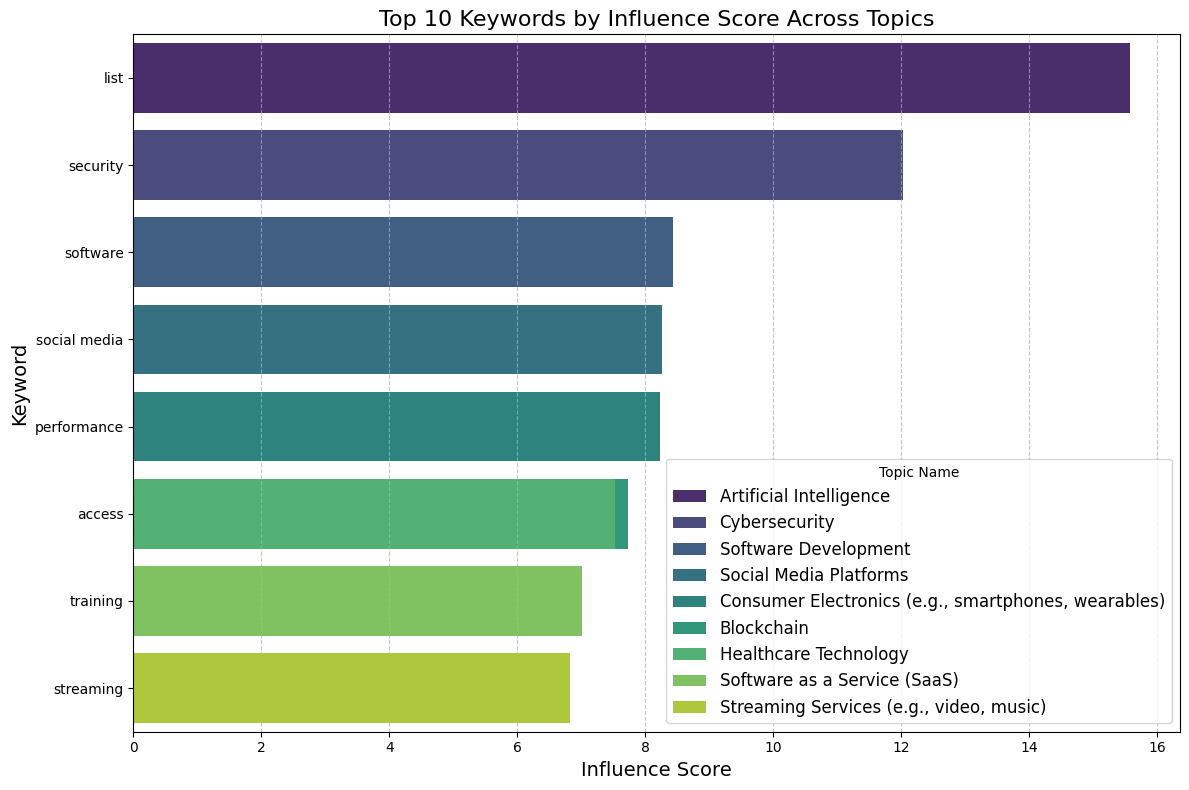

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_top_influential_keywords(influence_df, top_n=10):
    """
    Plots the top N keywords by influence score across all topics.

    Parameters:
        influence_df (DataFrame): DataFrame containing 'topic_name', 'keyword', and 'influence_score'.
        top_n (int): Number of top keywords to plot (default is 10).

    Returns:
        None
    """
    # Sort by influence score and select the top N keywords
    top_keywords = influence_df.sort_values(by="influence_score", ascending=False).head(top_n)

    # Create a bar plot
    plt.figure(figsize=(12, 8))
    sns.barplot(
        data=top_keywords,
        x="influence_score",
        y="keyword",
        hue="topic_name",
        dodge=False,  # Show topics side-by-side on the same row if repeated
        palette="viridis"
    )
    plt.title(f"Top {top_n} Keywords by Influence Score Across Topics", fontsize=16)
    plt.xlabel("Influence Score", fontsize=14)
    plt.ylabel("Keyword", fontsize=14)
    plt.legend(title="Topic Name", fontsize=12, loc="lower right")
    plt.grid(axis="x", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()

# Usage Example
plot_top_influential_keywords(influence_df, top_n=10)


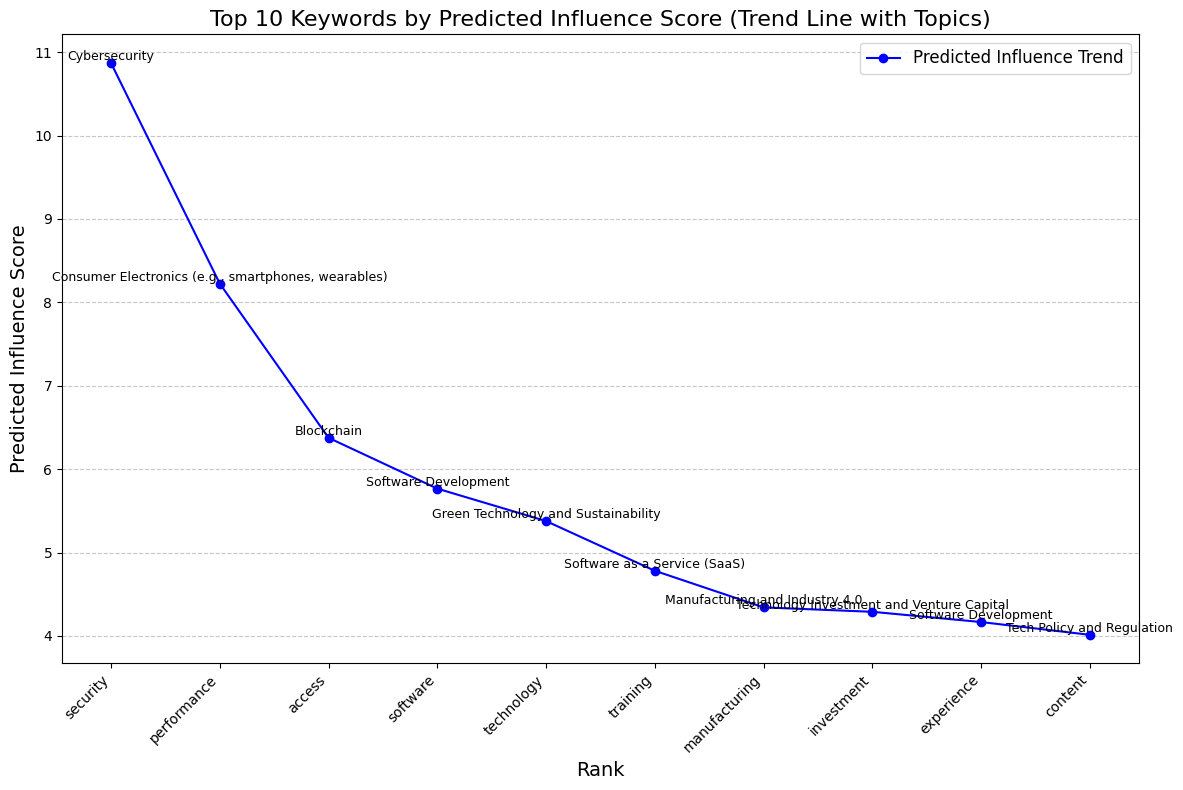


Model Performance:
Mean Absolute Error (MAE): 0.49
R² Score: -0.11


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import pandas as pd

def plot_influence_line_graph_with_predictions(influence_df, top_n=10):
    """
    Plots a line graph of the top N keywords by predicted influence score across all topics,
    with points labeled by the topic name.

    Parameters:
        influence_df (DataFrame): DataFrame containing 'topic_name', 'keyword', and 'influence_score'.
        top_n (int): Number of top keywords to plot (default is 10).

    Returns:
        model: Trained machine learning model.
        performance: Dictionary containing model evaluation metrics (MAE, R²).
    """
    # Prepare features and target
    X = influence_df[["topic_name", "keyword"]]
    y = influence_df["influence_score"]

    # One-hot encode categorical features
    encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
    X_encoded = encoder.fit_transform(X)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

    # Train a Random Forest model
    model = RandomForestRegressor(n_estimators=10, random_state=42)
    model.fit(X_train, y_train)

    # Make predictions
    influence_df["predicted_score"] = model.predict(encoder.transform(X))

    # Evaluate the model
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    performance = {"MAE": mae, "R²": r2}

    # Sort by predicted influence score and select the top N
    top_keywords = influence_df.sort_values(by="predicted_score", ascending=False).head(top_n)
    top_keywords["rank"] = range(1, len(top_keywords) + 1)

    # Create the line plot
    plt.figure(figsize=(12, 8))
    plt.plot(
        top_keywords["rank"],
        top_keywords["predicted_score"],
        marker="o",
        linestyle="-",
        color="blue",
        label="Predicted Influence Trend"
    )

    # Annotate points with topic names
    for i, row in top_keywords.iterrows():
        plt.text(row["rank"], row["predicted_score"], row["topic_name"], fontsize=9, ha='center', va='bottom')

    # Customize the plot
    plt.title(f"Top {top_n} Keywords by Predicted Influence Score (Trend Line with Topics)", fontsize=16)
    plt.xlabel("Rank", fontsize=14)
    plt.ylabel("Predicted Influence Score", fontsize=14)
    plt.xticks(top_keywords["rank"], labels=top_keywords["keyword"], rotation=45, ha="right", fontsize=10)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()

    # Return the model and performance
    return model, performance

# Usage Example
# Assume `influence_df` is a DataFrame with 'topic_name', 'keyword', and 'influence_score' columns
model, performance = plot_influence_line_graph_with_predictions(influence_df, top_n=10)

print("\nModel Performance:")
print(f"Mean Absolute Error (MAE): {performance['MAE']:.2f}")
print(f"R² Score: {performance['R²']:.2f}")

# Distinct Article Count by Industry

In [ ]:
def get_article_count_by_industry():
    with driver.session() as session:
        result = session.run(
            """
            MATCH (a:Article)-[]->(n)-[:BELONGS_TO_INDUSTRY]->(i:Industry)
            RETURN i.name AS industry, COUNT(DISTINCT a) AS article_count
            ORDER BY article_count DESC
            LIMIT 10
            """
        )

        # Convert results to DataFrame
        data = [{"industry_name": record["industry"], "article_count": record["article_count"]} for record in result]
        df = pd.DataFrame(data)

        return df

# Usage
article_count_by_industry_df = get_article_count_by_industry()
display(article_count_by_industry_df)



,industry_name,article_count
0,Communications and Media,1979
1,Software and Platforms,1516
2,High Tech,1400
3,Public Service,1161
4,Consumer Goods and Services,954
5,Banking,799
6,Health,701
7,Capital Markets,632
8,Retail,491
9,US Federal Government,364


In [ ]:
import plotly.express as px

In [ ]:
article_count_by_industry_df = get_article_count_by_industry()

# Create bubble chart
fig = px.scatter(
    article_count_by_industry_df,
    x="industry_name",
    y="article_count",
    size="article_count",
    color="industry_name",
    title="Top 10 Industries by Article Count",
    labels={"industry_name": "Industry", "article_count": "Article Count"},
    hover_name="industry_name",
)

# Show plot
fig.show()

# Sentiment Analysis and Trend Forecasting by Industry and Keyword


In [ ]:
def get_sentiment_trend_industry():
    with driver.session() as session:
        result = session.run(
            """
            MATCH (i:Industry)<-[:BELONGS_TO_INDUSTRY]-(n)-[:MENTIONS]-(a:Article)
            WHERE a.publication_date IS NOT NULL AND a.sentiment IS NOT NULL
            WITH i.name AS industry,
                date.truncate('month', a.publication_date) AS month_year,
                a.sentiment AS sentiment
            RETURN industry,
                month_year.year AS year,
                month_year.month AS month,
                AVG(sentiment) AS avg_sentiment
            ORDER BY year, month, industry;

            """
        )

        # Convert results to DataFrame
        data = [{"industry": record["industry"], "year": record["year"], "month": record["month"], "avg_sentiment": record["avg_sentiment"]} for record in result]
        df = pd.DataFrame(data)

        return df

# Usage
sentiment_trend_industry_df = get_sentiment_trend_industry()
display(sentiment_trend_industry_df)

,industry,year,month,avg_sentiment
0,Banking,2019,3,0.100000
1,Communications and Media,2019,3,0.475000
2,Consumer Goods and Services,2019,3,0.850000
3,Health,2019,3,0.100000
4,High Tech,2019,3,0.850000
...,...,...,...,...
299,Consumer Goods and Services,2023,11,0.500000
300,Health,2023,11,0.616667
301,High Tech,2023,11,0.675000
302,Public Service,2023,11,0.500000


<ipython-input-24-3f309b2b4523>:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmereo_9h/lxruf9j3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmereo_9h/3yw657bh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16469', 'data', 'file=/tmp/tmpmereo_9h/lxruf9j3.json', 'init=/tmp/tmpme

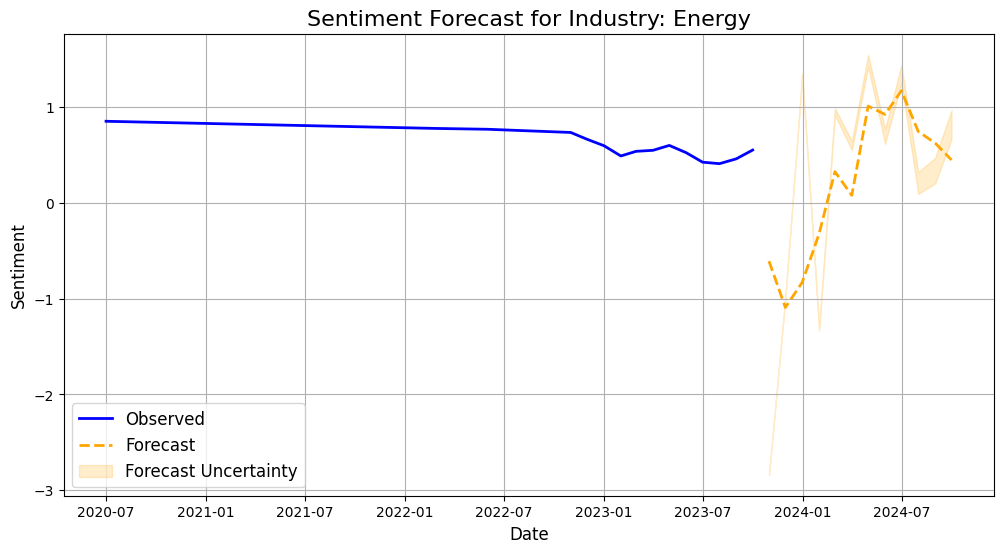

<ipython-input-24-3f309b2b4523>:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 14.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmereo_9h/xdi_o49_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmereo_9h/i5tv4589.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33246', 'data', 'file=/tmp/tmpmereo_9h/xdi_o49_.json', 'init=/tmp/tmpme

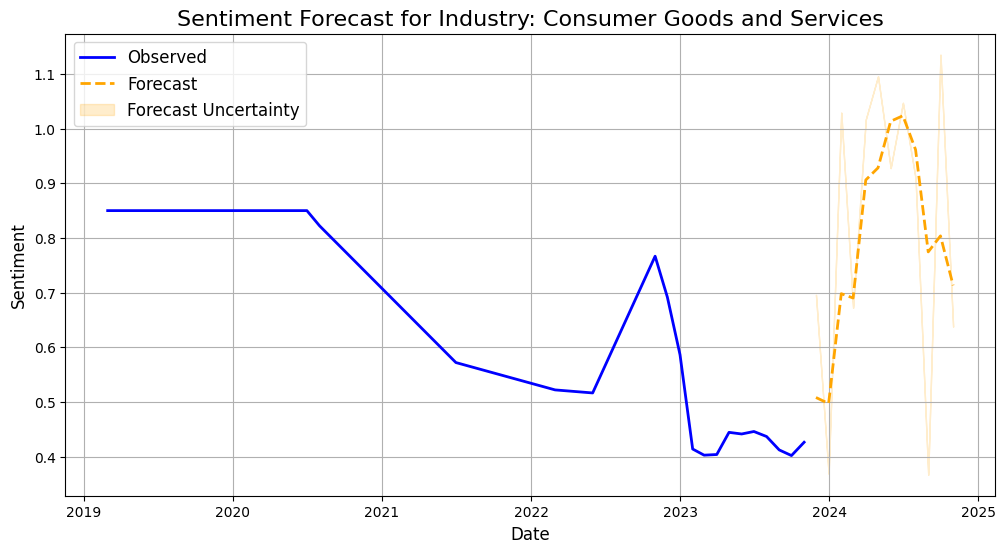

<ipython-input-24-3f309b2b4523>:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 8.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmereo_9h/dgod7tb1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmereo_9h/adv0c2ck.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92158', 'data', 'file=/tmp/tmpmereo_9h/dgod7tb1.json', 'init=/tmp/tmpmer

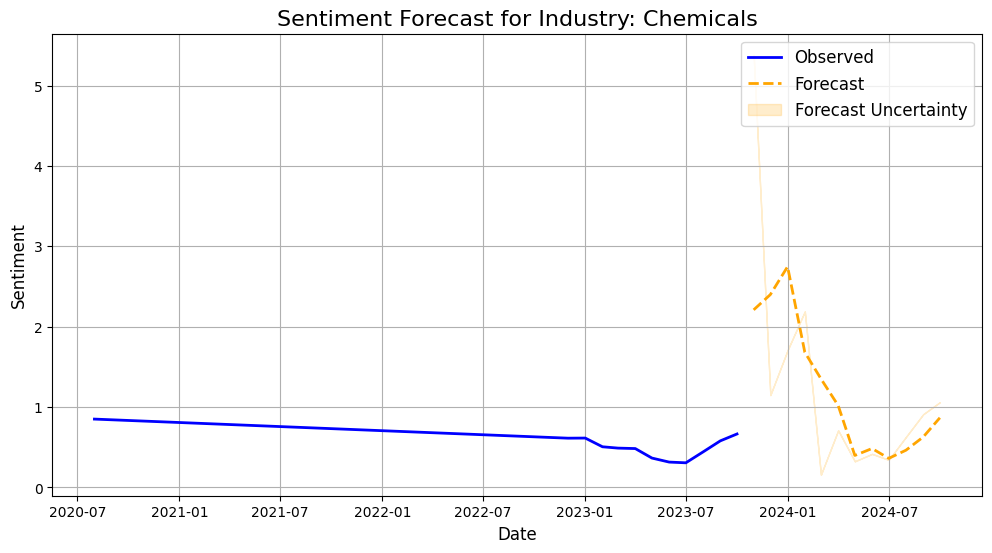

<ipython-input-24-3f309b2b4523>:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 14.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmereo_9h/6vpofrbb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmereo_9h/w6a27w84.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68112', 'data', 'file=/tmp/tmpmereo_9h/6vpofrbb.json', 'init=/tmp/tmpme

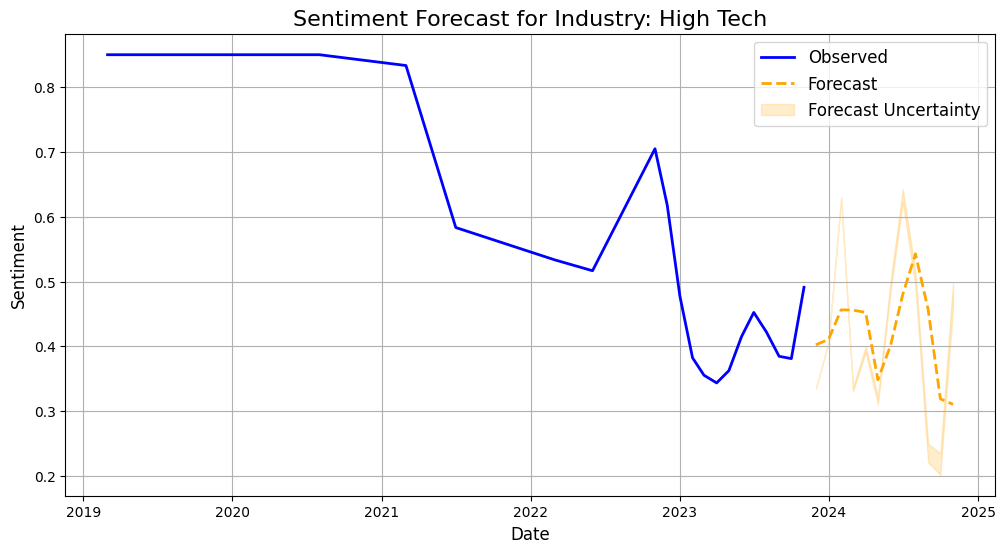

<ipython-input-24-3f309b2b4523>:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 17.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmereo_9h/h3gzhos_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmereo_9h/ej9i5okh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69892', 'data', 'file=/tmp/tmpmereo_9h/h3gzhos_.json', 'init=/tmp/tmpme

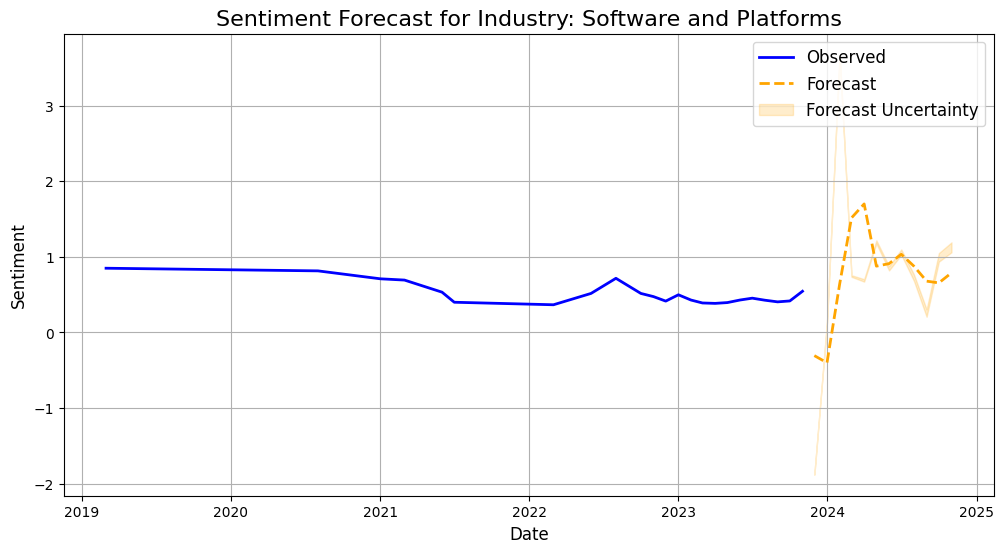

<ipython-input-24-3f309b2b4523>:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmereo_9h/60vh17n5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmereo_9h/ld4jnrgf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11086', 'data', 'file=/tmp/tmpmereo_9h/60vh17n5.json', 'init=/tmp/tmpme

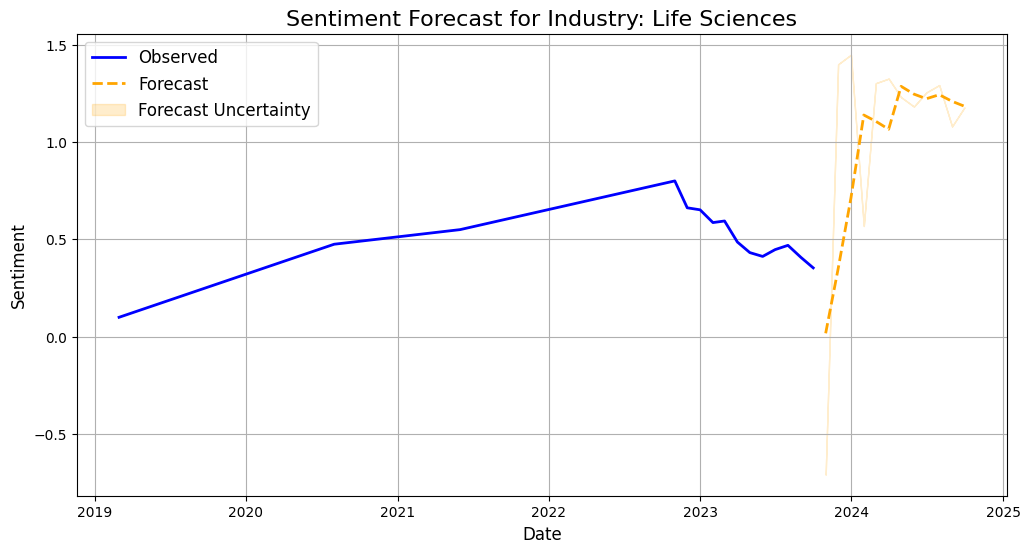

<ipython-input-24-3f309b2b4523>:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 9.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmereo_9h/6wwe7qbg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmereo_9h/ubxdmwyn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81672', 'data', 'file=/tmp/tmpmereo_9h/6wwe7qbg.json', 'init=/tmp/tmpmer

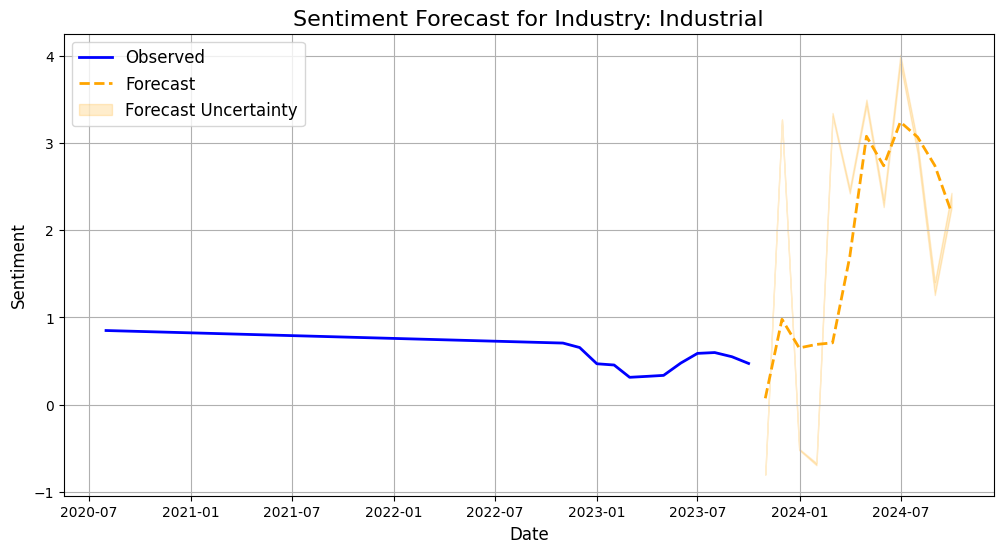

<ipython-input-24-3f309b2b4523>:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 8.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmereo_9h/3sfedkvq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmereo_9h/r7nohzqd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16078', 'data', 'file=/tmp/tmpmereo_9h/3sfedkvq.json', 'init=/tmp/tmpmer

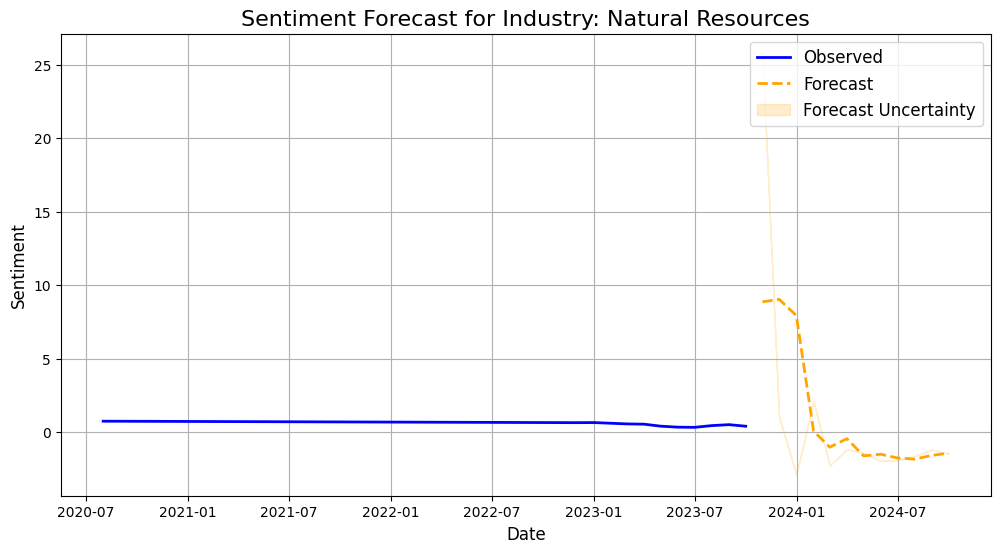

<ipython-input-24-3f309b2b4523>:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 17.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmereo_9h/7esxbk7l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmereo_9h/vyia32ws.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81142', 'data', 'file=/tmp/tmpmereo_9h/7esxbk7l.json', 'init=/tmp/tmpme

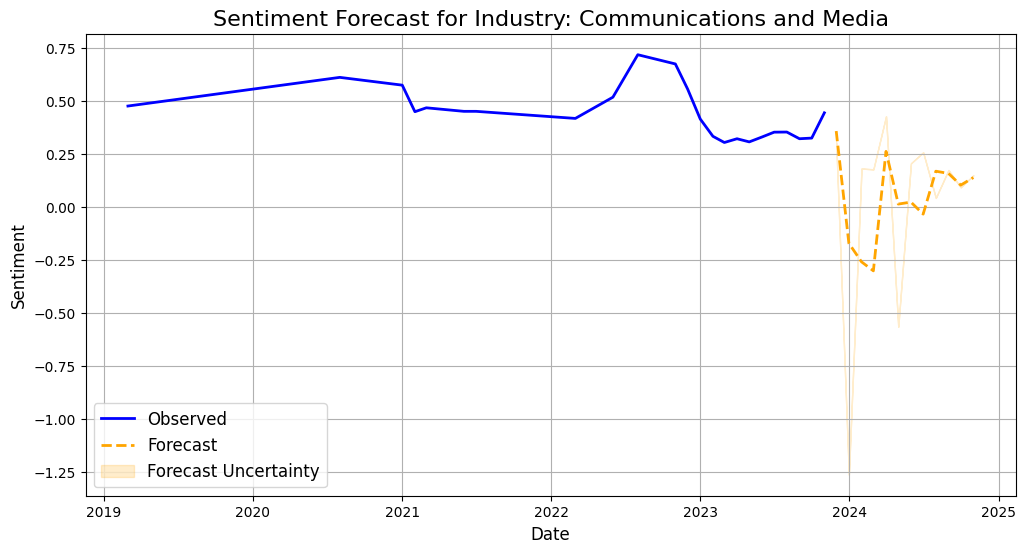

<ipython-input-24-3f309b2b4523>:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmereo_9h/mon5wi_u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmereo_9h/yhelwyt1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72268', 'data', 'file=/tmp/tmpmereo_9h/mon5wi_u.json', 'init=/tmp/tmpme

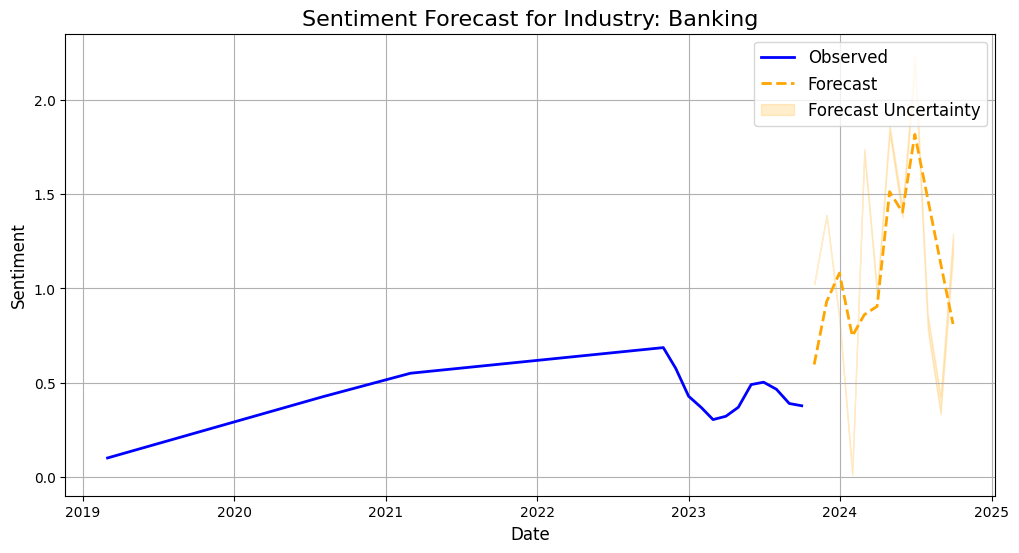

In [ ]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt

# Load sentiment trend data
sentiment_trend_industry_df = get_sentiment_trend_industry()

# Filter data for top industries
top_industries = sentiment_trend_industry_df.groupby('industry')['avg_sentiment'].mean().nlargest(10).index
filtered_data = sentiment_trend_industry_df[sentiment_trend_industry_df['industry'].isin(top_industries)]

# Forecast for each industry
for industry in top_industries:
    industry_data = filtered_data[filtered_data['industry'] == industry]

    # Prepare data for Prophet
    industry_data['date'] = pd.to_datetime(industry_data[['year', 'month']].assign(day=1))
    prophet_data = industry_data[['date', 'avg_sentiment']].rename(columns={'date': 'ds', 'avg_sentiment': 'y'})

    # Smooth the data with a rolling average (optional)
    prophet_data['y'] = prophet_data['y'].rolling(window=3, min_periods=1).mean()

    # Fit Prophet model with tuned parameters
    model = Prophet(
        yearly_seasonality=True,
        changepoint_prior_scale=0.05,  # Control trend flexibility
        seasonality_mode='additive'  # Use additive seasonality
    )
    model.add_seasonality(name='monthly', period=30.5, fourier_order=5)  # Monthly seasonality
    model.fit(prophet_data)

    # Make predictions for the next 12 months
    future = model.make_future_dataframe(periods=12, freq='M')
    forecast = model.predict(future)

    # Smooth the forecast results
    forecast['yhat'] = forecast['yhat'].rolling(window=3, min_periods=1).mean()

    # Plot observed vs forecasted data
    plt.figure(figsize=(12, 6))

    # Plot observed data
    plt.plot(
        prophet_data['ds'],
        prophet_data['y'],
        label='Observed',
        color='blue',
        linewidth=2
    )

    # Plot forecasted data
    forecast_data = forecast[forecast['ds'] > prophet_data['ds'].max()]
    plt.plot(
        forecast_data['ds'],
        forecast_data['yhat'],
        label='Forecast',
        color='orange',
        linestyle='--',
        linewidth=2
    )

    # Highlight uncertainty intervals
    plt.fill_between(
        forecast_data['ds'],
        forecast_data['yhat_lower'],
        forecast_data['yhat_upper'],
        color='orange',
        alpha=0.2,
        label='Forecast Uncertainty'
    )

    # Add labels and title
    plt.title(f"Sentiment Forecast for Industry: {industry}", fontsize=16)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Sentiment", fontsize=12)
    plt.legend(fontsize=12)
    plt.grid()
    plt.show()


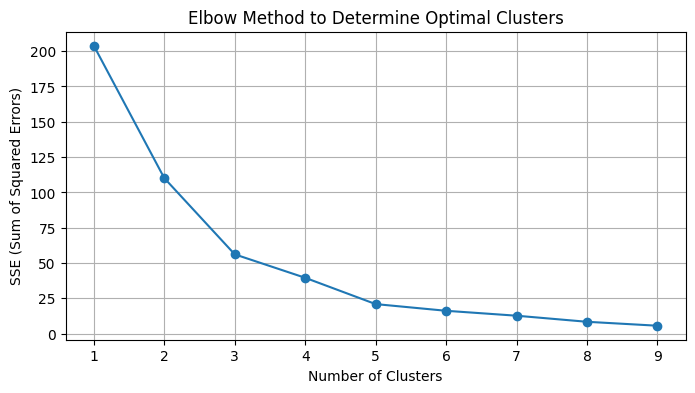

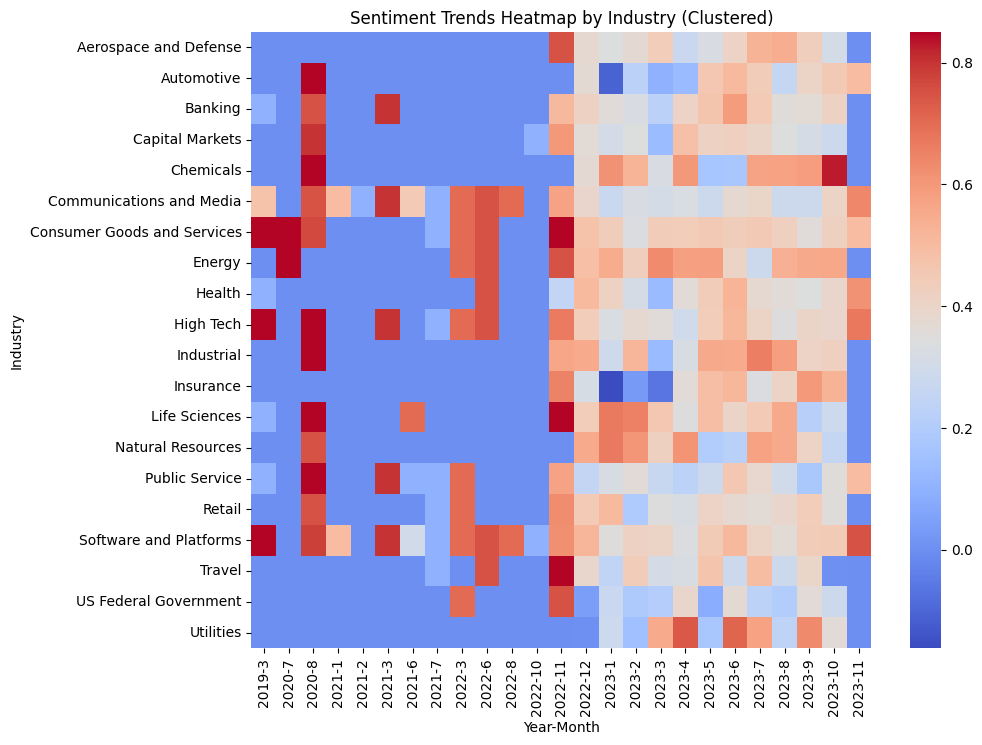

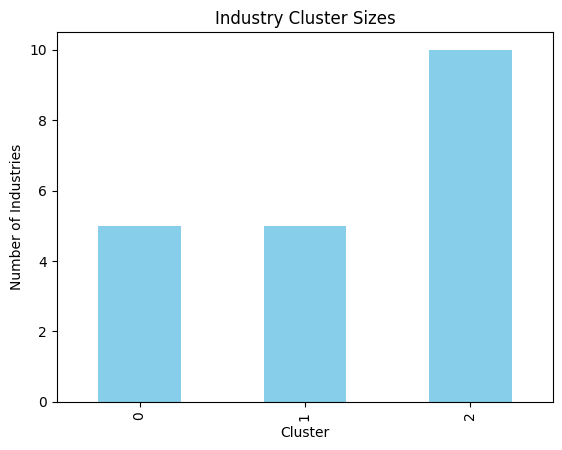

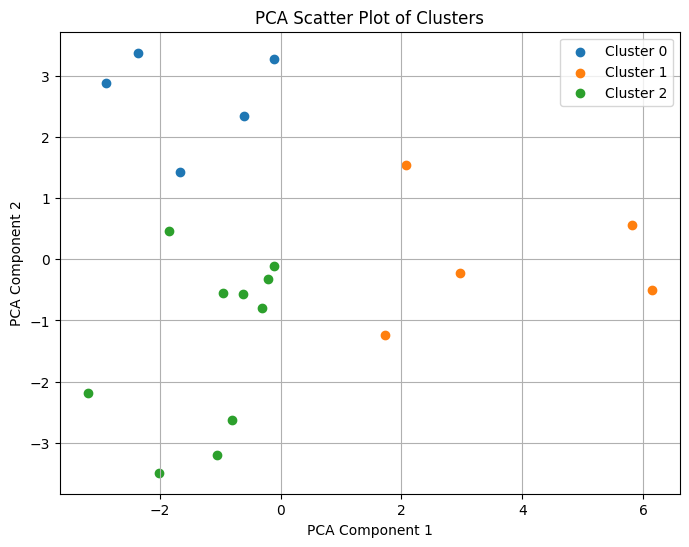

In [ ]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Prepare data for clustering
pivot_data = sentiment_trend_industry_df.pivot_table(index=['industry'], columns=['year', 'month'], values='avg_sentiment', fill_value=0)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(pivot_data)

# Step 2: Apply PCA to reduce dimensionality for better clustering
pca = PCA(n_components=2)  # Reduce to 2 dimensions for visualization
pca_data = pca.fit_transform(scaled_data)

# Step 3: Determine optimal number of clusters using elbow method
sse = []
for k in range(1, 10):  # Test 1 to 10 clusters
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_data)
    sse.append(kmeans.inertia_)

# Plot the elbow graph
plt.figure(figsize=(8, 4))
plt.plot(range(1, 10), sse, marker='o')
plt.title("Elbow Method to Determine Optimal Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("SSE (Sum of Squared Errors)")
plt.grid()
plt.show()

# Step 4: Apply KMeans with tuned number of clusters (e.g., 3 based on elbow graph)
optimal_clusters = 3  # Choose based on the elbow method
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
pivot_data['Cluster'] = kmeans.fit_predict(pca_data)

# Step 5: Visualize the clusters
# Add clusters back to original data
pivot_data['Cluster'] = kmeans.labels_

# Plot heatmap with clusters
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_data.drop(columns=['Cluster']), cmap='coolwarm')
plt.title("Sentiment Trends Heatmap by Industry (Clustered)")
plt.xlabel("Year-Month")
plt.ylabel("Industry")
plt.show()

# Bar plot of cluster memberships
cluster_summary = pivot_data.groupby('Cluster').size()
cluster_summary.plot(kind='bar', title='Industry Cluster Sizes', ylabel='Number of Industries', xlabel='Cluster', color='skyblue')
plt.show()

# Step 6: Scatter plot of PCA results colored by cluster
plt.figure(figsize=(8, 6))
for cluster in range(optimal_clusters):
    cluster_points = pca_data[kmeans.labels_ == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster}")

plt.title("PCA Scatter Plot of Clusters")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.grid()
plt.show()


In [ ]:
import pandas as pd

# Create a mapping of industries to clusters
industry_cluster_mapping = pivot_data[['Cluster']].reset_index()

# Rename columns for clarity
industry_cluster_mapping.columns = ['Industry', 'Cluster']

# Display the mapping as a table
cluster_summary_table = industry_cluster_mapping.groupby('Cluster')['Industry'].apply(list).reset_index()

# Print or display the summary table
print(cluster_summary_table)


   Cluster                                           Industry
0        0  [Chemicals, Energy, Industrial, Life Sciences,...
1        1  [Communications and Media, Consumer Goods and ...
2        2  [Aerospace and Defense, Automotive, Banking, C...


In [ ]:
import numpy as np
import pandas as pd

# Step 1: Calculate distances of each industry to its cluster centroid in PCA space
centroids = kmeans.cluster_centers_  # Cluster centroids in PCA space
distances = np.zeros(len(pca_data))  # To store distances

# Compute distances for each industry
for i, point in enumerate(pca_data):
    cluster_label = kmeans.labels_[i]
    centroid = centroids[cluster_label]
    distances[i] = np.linalg.norm(point - centroid)

# Step 2: Create a DataFrame for industries with their cluster labels and distances
industry_distances_df = pd.DataFrame({
    'Industry': pivot_data.index,
    'Cluster': kmeans.labels_,
    'Distance': distances
})

# Step 3: Find the 4 closest industries for each cluster
closest_industries = (
    industry_distances_df.groupby('Cluster')
    .apply(lambda group: group.nsmallest(4, 'Distance'))  # Get 4 closest points
    .reset_index(drop=True)
)

# Step 4: Print the closest industries for each cluster
print("Closest Industries to Each Cluster Centroid:")
for cluster in range(optimal_clusters):
    print(f"\nCluster {cluster}:")
    cluster_industries = closest_industries[closest_industries['Cluster'] == cluster]
    print(cluster_industries[['Industry', 'Distance']])


Closest Industries to Each Cluster Centroid:

Cluster 0:
            Industry  Distance
0             Energy  0.973175
1  Natural Resources  1.096958
2         Industrial  1.235347
3          Chemicals  1.379657

Cluster 1:
                      Industry  Distance
4                    High Tech  0.821649
5       Software and Platforms  2.139420
6  Consumer Goods and Services  2.252282
7               Public Service  2.375246

Cluster 2:
           Industry  Distance
8   Capital Markets  0.804953
9           Banking  0.914025
10           Health  0.972497
11       Automotive  1.325489


<ipython-input-37-4464e54366c2>:24: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-p

                             precision    recall  f1-score   support

      Aerospace and Defense       0.00      0.00      0.00         2
                 Automotive       0.00      0.00      0.00         4
                    Banking       0.00      0.00      0.00         2
            Capital Markets       0.00      0.00      0.00         5
                  Chemicals       0.00      0.00      0.00         2
   Communications and Media       0.08      0.40      0.13         5
Consumer Goods and Services       0.00      0.00      0.00         1
                     Energy       0.00      0.00      0.00         4
                     Health       0.00      0.00      0.00         3
                  High Tech       0.00      0.00      0.00         2
                 Industrial       0.00      0.00      0.00         4
                  Insurance       0.00      0.00      0.00         1
              Life Sciences       0.00      0.00      0.00         4
          Natural Resources      

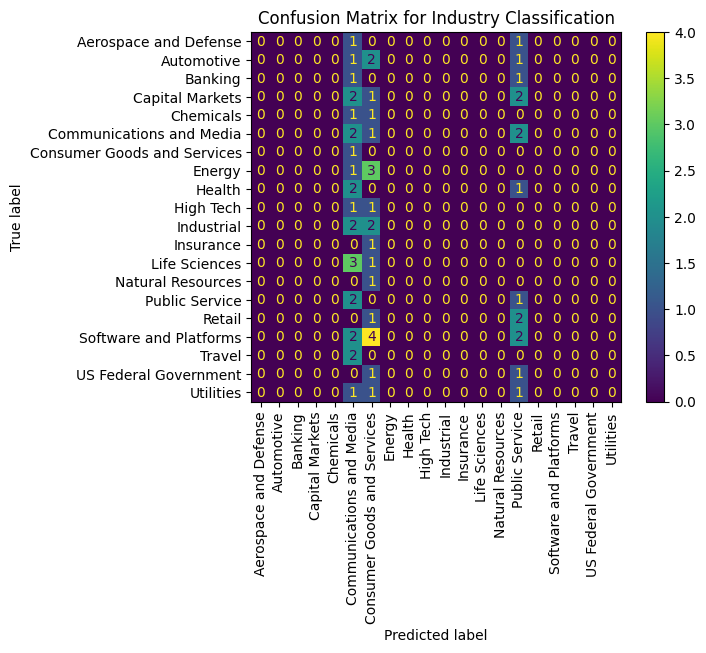

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Prepare data
sentiment_trend_industry_df['date'] = pd.to_datetime(sentiment_trend_industry_df[['year', 'month']].assign(day=1))
X = sentiment_trend_industry_df[['avg_sentiment', 'year', 'month']]
y = sentiment_trend_industry_df['industry']

# Encode target labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Train logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Visualize confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=label_encoder.classes_, xticks_rotation='vertical')
plt.title("Confusion Matrix for Industry Classification")
plt.show()


In [ ]:
def get_sentiment_trend_keyword():
    with driver.session() as session:
        result = session.run(
            """
            MATCH (k:Keyword)<-[:MENTIONS]-(a:Article)
            WHERE a.publication_date IS NOT NULL AND a.sentiment IS NOT NULL
            WITH k.name AS keyword,
                date.truncate('month', a.publication_date) AS month_year,
                a.sentiment AS sentiment
            RETURN keyword,
                month_year.year AS year,
                month_year.month AS month,
                AVG(sentiment) AS avg_sentiment
            ORDER BY year, month, keyword;
            """
        )

        # Convert results to DataFrame
        data = [{"keyword": record["keyword"], "year": record["year"], "month": record["month"], "avg_sentiment": record["avg_sentiment"]} for record in result]
        df = pd.DataFrame(data)

        return df

# Usage
sentiment_trend_keyword_df = get_sentiment_trend_keyword()
display(sentiment_trend_keyword_df)


,keyword,year,month,avg_sentiment
0,format,2014,3,0.750
1,list,2014,3,0.750
2,Breaking News,2019,3,0.100
3,Business News,2019,3,0.100
4,Latest News Updates,2019,3,0.100
...,...,...,...,...
6701,website,2023,10,-0.225
6702,weight,2023,10,0.300
6703,workforce,2023,10,-0.200
6704,workshops,2023,10,0.950


# Distinct Article Count by Organzation




In [ ]:
def get_article_count_by_organization():
    with driver.session() as session:
        result = session.run(
            """
            MATCH (a:Article)-[:MENTIONS]->(o:Organization)
            RETURN o.name AS organization, COUNT(DISTINCT a) AS article_count
            ORDER BY article_count DESC
            LIMIT 10
            """
        )

        # Convert results to DataFrame
        data = [{"organization": record["organization"], "article_count": record["article_count"]} for record in result]
        df = pd.DataFrame(data)

        return df

# Usage
article_count_by_organization_df = get_article_count_by_organization()
display(article_count_by_organization_df)




,organization,article_count
0,Microsoft,173
1,Google,168
2,Amazon,142
3,Apple,108
4,LinkedIn,105
5,OpenAI,90
6,Meta,63
7,IBM,51
8,Netflix,47
9,The Motley Fool,45


In [ ]:
# Create bubble chart
fig = px.scatter(
    article_count_by_organization_df,
    x="organization",
    y="article_count",
    size="article_count",
    color="organization",
    title="Top 10 Organizations by Article Count",
    labels={"organization": "Organization", "article_count": "Article Count"},
    hover_name="organization",
)

# Adjust layout for better readability
fig.update_layout(
    xaxis_tickangle=-45,
    showlegend=False  # Hide legend if there are too many items
)

# Show plot
fig.show()


# Sentiment Analysis and Trend Forecasting

**Step 1: Get the historal data from Neo4j database**




In [ ]:
# Get the historal data from Neo4j database
def get_sentiment_trend_organization():
    """
    Retrieves sentiment trends over time for organizations from the Neo4j knowledge graph.

    Returns:
        df (pd.DataFrame): A DataFrame containing organization names, year, month, and average sentiment.
    """
    with driver.session() as session:
        result = session.run(
            """
            MATCH (o:Organization)<-[:MENTIONS]-(a:Article)
            WHERE a.publication_date IS NOT NULL
              AND a.sentiment IS NOT NULL
              AND o.name IS NOT NULL
            WITH o.name AS organization,
                 date.truncate('month', a.publication_date) AS month_year,
                 a.sentiment AS sentiment
            RETURN organization,
                   month_year.year AS year,
                   month_year.month AS month,
                   AVG(sentiment) AS avg_sentiment
            ORDER BY year, month, organization
            """
        )

        # Convert results to DataFrame
        data = [
            {
                "organization": record["organization"],
                "year": record["year"],
                "month": record["month"],
                "avg_sentiment": record["avg_sentiment"]
            }
            for record in result
        ]
        df = pd.DataFrame(data)

        return df

# Usage
sentiment_trend_organization_df = get_sentiment_trend_organization()
display(sentiment_trend_organization_df)

,organization,year,month,avg_sentiment
0,Avegant,2019,3,0.85
1,Bharat Biotech,2019,3,0.10
2,CastAR,2019,3,0.85
3,ET Prime,2019,3,0.10
4,ICICI Bank,2019,3,0.10
...,...,...,...,...
15268,Salesforce,2023,11,0.85
15269,Volkswagen,2023,11,0.50
15270,West Midlands police,2023,11,0.50
15271,diginomica,2023,11,0.85


**Step 2: Select specific organization and analyze its sentiment trend over time**

In [ ]:
# Select an organization to analyze
organization_to_analyze = 'Salesforce'  # We can replace with an actual organization name, we use the Salesforce as an example

# Filter data for the selected organization
org_df = sentiment_trend_organization_df[sentiment_trend_organization_df['organization'] == organization_to_analyze]

# Convert 'year' and 'month' to datetime
org_df['date'] = pd.to_datetime(org_df[['year', 'month']].assign(DAY=1))

# Sort the DataFrame by date
org_df = org_df.sort_values('date')

# Reset index
org_df.reset_index(drop=True, inplace=True)

# Display the organization's sentiment trend data
display(org_df)

<ipython-input-23-faac5f9946cf>:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,organization,year,month,avg_sentiment,date
0,Salesforce,2022,12,0.675000,2022-12-01
1,Salesforce,2023,2,-0.010000,2023-02-01
2,Salesforce,2023,3,0.414286,2023-03-01
3,Salesforce,2023,4,0.783333,2023-04-01
4,Salesforce,2023,5,1.000000,2023-05-01
5,Salesforce,2023,6,0.700000,2023-06-01
6,Salesforce,2023,7,0.725000,2023-07-01
7,Salesforce,2023,8,0.083333,2023-08-01
8,Salesforce,2023,9,0.583333,2023-09-01
9,Salesforce,2023,10,0.733333,2023-10-01


In [ ]:
# Plot the sentiment trend over time
fig = px.line(
    org_df,
    x='date',
    y='avg_sentiment',
    title=f'Average Sentiment Over Time for {organization_to_analyze}',
    labels={'avg_sentiment': 'Average Sentiment', 'date': 'Date'},
    markers=True
)

# Show plot
fig.show()

**Step 3:Trend Forecasting Using SARIMAX Model for future predication**

In [ ]:
pip install statsmodels

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [ ]:
# We'll use the SARIMAX model from the statsmodels library to forecast future sentiment trends.
# Prepare data for time series forecasting
# Set 'date' as the index
org_ts = org_df.set_index('date')['avg_sentiment']

# Ensure the index is a datetime index
org_ts.index = pd.DatetimeIndex(org_ts.index).to_period('M')

# Display the time series data
print(org_ts.head())

date
2022-12    0.675000
2023-02   -0.010000
2023-03    0.414286
2023-04    0.783333
2023-05    1.000000
Freq: M, Name: avg_sentiment, dtype: float64


In [ ]:
# Fit the SARIMAX Model:
# Define the SARIMAX model
model = SARIMAX(org_ts, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))

# Fit the model
model_fit = model.fit(disp=False)

# Display model summary
print(model_fit.summary())


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

/usr/local/lib/python3.10/dist-packages/statsmodels/tools/eval_measures.py:414: RuntimeWarning:

invalid value encountered in log

/usr/local/lib/python3.10/dist-packages/statsmodels/tools/eval_measures.py:439: RuntimeWarning:

invalid value encountered in log

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/mlemodel.py:3016: RuntimeWarning:

divide by zero encountered in divide

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/mlemodel.py:3016: RuntimeWarning:

invalid value encountered in divide



                                     SARIMAX Results                                      
Dep. Variable:                      avg_sentiment   No. Observations:                   11
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                   0.000
Date:                            Sat, 30 Nov 2024   AIC                             10.000
Time:                                    01:06:14   BIC                                nan
Sample:                                12-31-2022   HQIC                               nan
                                     - 11-30-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1               0         -0        nan        nan           0           0
ma.L1               0         -0   

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:472: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning:

invalid value encountered in scalar divide



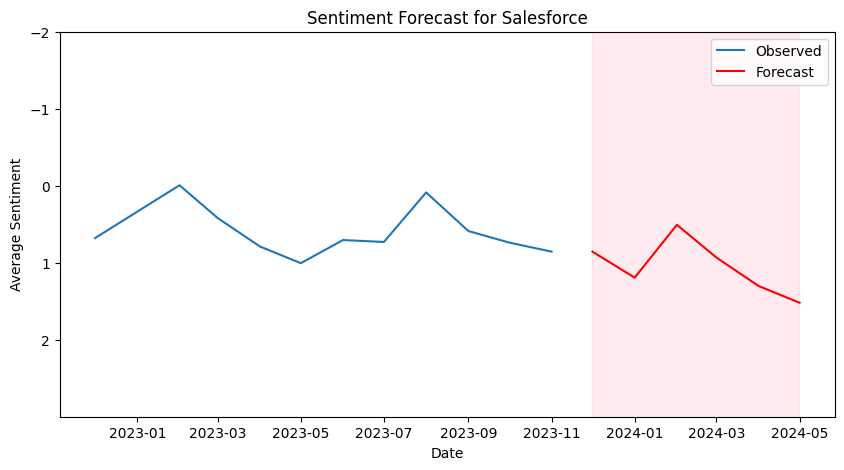

In [ ]:
# Forecast Future Sentiment:
# Forecast the next 6 months
import matplotlib.pyplot as plt
forecast_period = 6
forecast = model_fit.get_forecast(steps=forecast_period)
forecast_index = pd.date_range(start=org_ts.index[-1].to_timestamp(), periods=forecast_period+1, freq='ME')[1:]
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Convert forecast index to PeriodIndex
forecast_index = forecast_index.to_period('M')

# Plot the observed data and the forecast
plt.figure(figsize=(10, 5))
plt.plot(org_ts.index.to_timestamp(), org_ts, label='Observed')
plt.plot(forecast_index.to_timestamp(), forecast_mean, label='Forecast', color='red')
plt.fill_between(forecast_index.to_timestamp(), forecast_ci['lower avg_sentiment'], forecast_ci['upper avg_sentiment'], color='pink', alpha=0.3)
plt.title(f'Sentiment Forecast for {organization_to_analyze}')
plt.xlabel('Date')
plt.ylabel('Average Sentiment')
plt.ylim([org_ts.min()+ 3, org_ts.max() - 3])
plt.legend()
plt.show()


Naned Entity Recognition using Hugging Face's "transformers" library

In [ ]:
from neo4j import GraphDatabase
from transformers import pipeline

# Connect to Neo4j
neo4j_pass_prof = "Fpz12jA1x46VDU0j53kGGTspKb1nVgeqT5xb3mYeNI0"
driver = GraphDatabase.driver("neo4j+s://2003b312.databases.neo4j.io", auth=("neo4j", neo4j_pass_prof))

# Initialize Named Entity Recognition (NER) pipeline
ner_pipeline = pipeline("ner", model="dbmdz/bert-large-cased-finetuned-conll03-english")

# Fetch a maximum of 10 articles from Neo4j
def fetch_articles(limit=10):
    with driver.session() as session:
        result = session.run(
            """
            MATCH (a:Article)
            RETURN a.name AS name, a.title AS title
            LIMIT $limit
            """,
            limit=limit
        )
        return [{"name": record["name"], "title": record["title"]} for record in result]

# Perform NER and update Neo4j
def process_articles(limit=10):
    articles = fetch_articles(limit)
    for article in articles:
        try:
            # Perform NER on the article title
            ner_results = ner_pipeline(article["title"])
            entities = [{"name": e["word"], "type": e["entity"]} for e in ner_results]

            # Update Neo4j with extracted entities
            with driver.session() as session:
                session.run(
                    """
                    MATCH (a:Article {name: $article_name})
                    UNWIND $entities AS entity
                    MERGE (e:Entity {name: entity.name, type: entity.type})
                    MERGE (a)-[:MENTIONS]->(e)
                    """,
                    article_name=article["name"],
                    entities=entities,
                )
            print(f"Processed: {article['name']}")

        except Exception as e:
            print(f"Error processing {article['name']}: {e}")

# Run the script for 10 articles
process_articles(limit=10)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning:


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.



config.json:   0%|          | 0.00/998 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/60.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

Processed: Article_7156948
Processed: Article_5580518
Processed: Article_6235280
Processed: Article_8534449
Processed: Article_1473966
Processed: Article_7103910
Processed: Article_3644042
Processed: Article_1538905
Processed: Article_1329660
Processed: Article_5019585


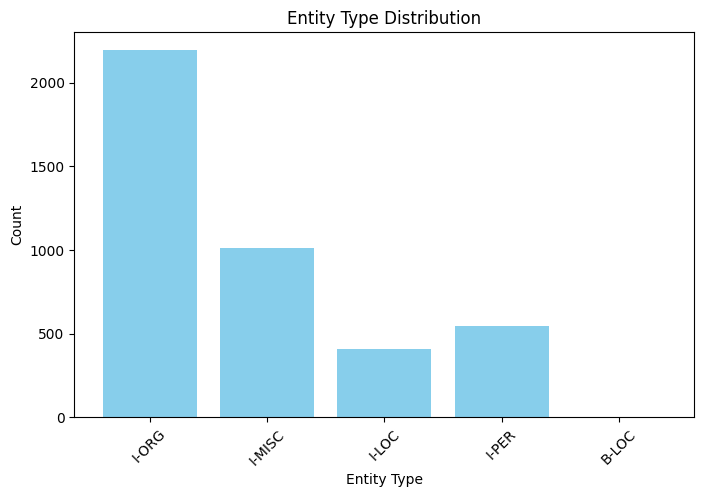

In [ ]:
from collections import Counter

# Fetch entity types from Neo4j
def fetch_entity_types():
    with driver.session() as session:
        result = session.run(
            """
            MATCH (e:Entity)
            RETURN e.type AS type
            """
        )
        return [record["type"] for record in result]

# Visualize entity type distribution
def visualize_entity_distribution(entity_types):
    counts = Counter(entity_types)
    plt.figure(figsize=(8, 5))
    plt.bar(counts.keys(), counts.values(), color="skyblue")
    plt.title("Entity Type Distribution")
    plt.xlabel("Entity Type")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.show()

# Fetch data and visualize
entity_types = fetch_entity_types()
visualize_entity_distribution(entity_types)


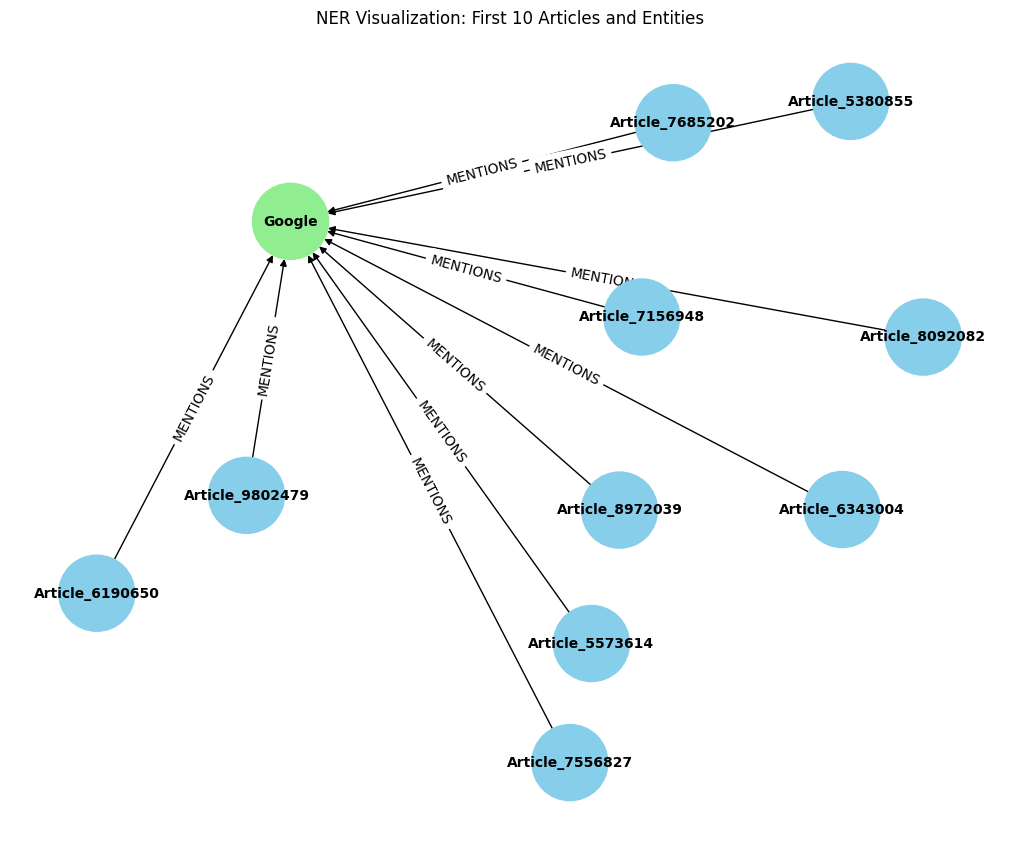

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

# Fetch relationships for the first 10 articles
def fetch_first_10_mentions():
    with driver.session() as session:
        result = session.run(
            """
            MATCH (a:Article)-[:MENTIONS]->(e:Entity)
            RETURN a.name AS article, e.name AS entity, e.type AS type
            LIMIT 10
            """
        )
        return [{"article": record["article"], "entity": record["entity"], "type": record["type"]} for record in result]

# Visualize the graph for the first 10 articles
def visualize_first_10_graph(mentions):
    # Create a graph
    G = nx.DiGraph()

    # Add edges and nodes for the first 10 articles
    for mention in mentions:
        G.add_node(mention["article"], label="Article", color="skyblue")
        G.add_node(mention["entity"], label=mention["type"], color="lightgreen")
        G.add_edge(mention["article"], mention["entity"], label="MENTIONS")

    # Position nodes in a spring layout
    pos = nx.spring_layout(G)

    # Draw the graph
    plt.figure(figsize=(10, 8))
    node_colors = [G.nodes[node].get("color", "gray") for node in G.nodes]
    nx.draw(
        G, pos, with_labels=True, node_size=3000, font_size=10, font_weight="bold", node_color=node_colors
    )
    labels = nx.get_edge_attributes(G, "label")
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
    plt.title("NER Visualization: First 10 Articles and Entities")
    plt.show()

# Fetch and visualize
mentions = fetch_first_10_mentions()
visualize_first_10_graph(mentions)
